In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
from    missingno import matrix
import scipy.stats as stats
from pathlib import Path
import fnmatch
from collections import defaultdict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Dropout, BatchNormalization, RepeatVector
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from time import time

# plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  # visualization
import matplotlib.pyplot as plt


In [ ]:
path = '/content/gdrive/My Drive/Thesis/3W_dataset/'

In [ ]:
# Reference table of variables

tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'degC',
         'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Temperature downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

Tag                                Name    Unit
Number                                                        
1            P-PDG                 Pressure at the PDG      Pa
2            P-TPT                 Pressure at the TPT      Pa
3            T-TPT              Temperature at the TPT    degC
4        P-MON-CKP        Pressure upstream of the PCK      Pa
5        T-JUS-CKP   Temperature downstream of the PCK    degC
6       P-JUS-CKGL     Pressure downstream of the GLCK      Pa
7       T-JUS-CKGL  Temperature downstream of the GLCK    degC
8              QGL                  Gas lift flow rate  sm^3/s

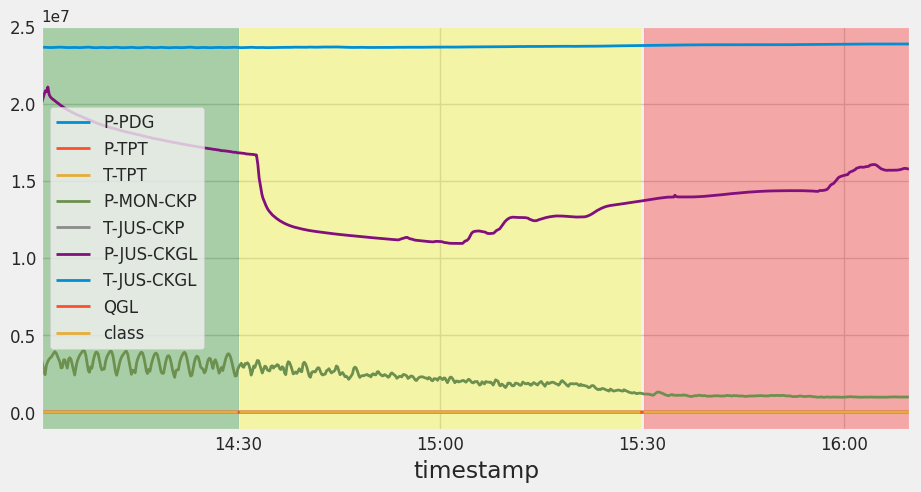

In [ ]:
# Vizualising one time series

df_single = pd.read_csv(path +"5/WELL-00015_20171013140047.csv")
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

# Convert the date column to a datestamp type
df_single['timestamp'] = pd.to_datetime(df_single['timestamp'])
df_single = df_single.set_index('timestamp')

ax = df_single.plot(linewidth=2, fontsize=12);

# Add a vertical red shaded region
ax.axvspan('2017-10-13 14:00:47', '2017-10-13  14:29:57', color='green', alpha=.3)
ax.axvspan('2017-10-13 14:30:15', '2017-10-13 15:29:45', color='yellow', alpha=.3)
ax.axvspan('2017-10-13 15:30:15', '2017-10-13 16:10:00', color='red', alpha=.3)

# Additional customizations
ax.set_xlabel('timestamp');
ax.legend(fontsize=12);

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


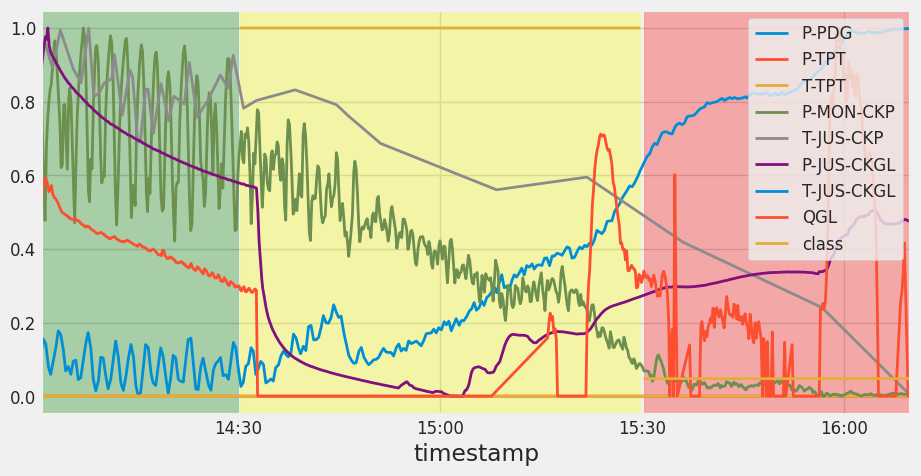

In [ ]:
# Rescale the features with MinMaxScaler

scaler = MinMaxScaler() 
df_scaled = pd.DataFrame(scaler.fit_transform(df_single.values),
                                     index=df_single.index,
                                     columns=df_single.columns)

ax = df_scaled.plot(linewidth=2, fontsize=12);

# Add a vertical red shaded region
ax.axvspan('2017-10-13 14:00:47', '2017-10-13  14:29:57', color='green', alpha=.3)
ax.axvspan('2017-10-13 14:30:15', '2017-10-13 15:29:45', color='yellow', alpha=.3)
ax.axvspan('2017-10-13 15:30:15', '2017-10-13 16:10:00', color='red', alpha=.3)

# Additional customizations
ax.set_xlabel('timestamp');
ax.legend(fontsize=12);

<ipython-input-36-74300376b8ff>:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout();


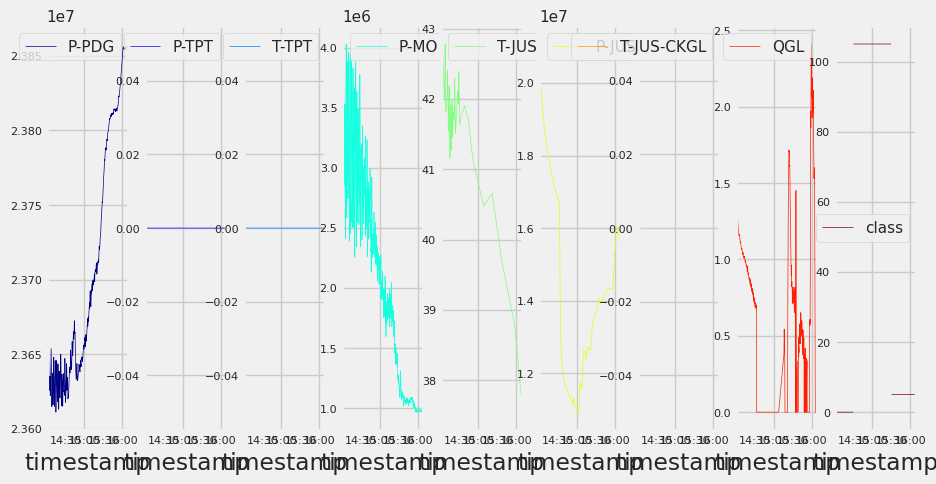

In [ ]:
df_single.plot(subplots=True,
          layout=(1, 9),
          sharex=False,
          sharey=False,
          colormap='jet',
          fontsize=8,
         legend=True,
         linewidth=0.5);
plt.tight_layout();

<Axes: xlabel='event', ylabel='count'>

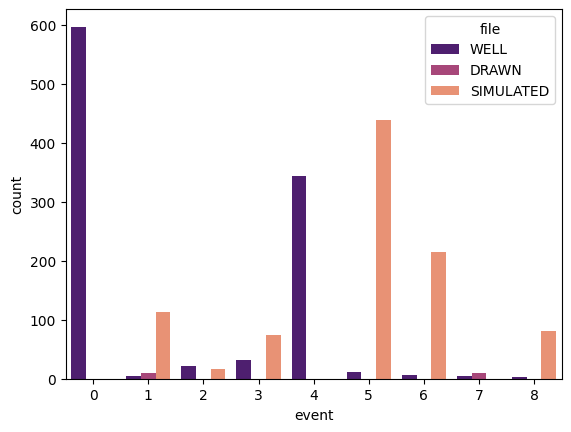

In [ ]:
# Vizualisation by data source: Well (Real), Simulated or Drawn

d=defaultdict(set)
for path,dirs,files in os.walk(path):
   for f in fnmatch.filter(files,'*.csv'):
      d[os.path.basename(path)].add(f)  

df = pd.Series(d).explode().reset_index(name='file')
df.rename(columns = {'index':'event'}, inplace = True)
df.loc[df['file'].str.contains('WELL'), "file"] = 'WELL'
df.loc[df['file'].str.contains('DRAWN'), "file"] = 'DRAWN'
df.loc[df['file'].str.contains('SIMULATED'), "file"] = 'SIMULATED'
df_new = df.groupby(["event", "file"]).size().reset_index(name='count')
sns.barplot(data=df_new, x="event", y="count", hue="file", palette = 'magma')

In [ ]:
# Selecting WELL files, leaving just real instances

file_list = [] #empty list

for root, dirs, files in os.walk(path):
  #if "7" in dirs:
   #     dirs.remove("7")
  
  for file in files:
    file_list.append(str(os.path.join(root,file)))

file_list = [i for i in file_list if "WELL" in i]
len(file_list)

1025

In [ ]:
# Vizualisation by data source: Well (Real)
path = '/content/gdrive/My Drive/Thesis/3W_dataset/'
d=defaultdict(set)
for path,dirs,files in os.walk(path):
   for f in fnmatch.filter(files,'*.csv'):
     if f.startswith("WELL"):
        d[os.path.basename(path)].add(f)
     
df = pd.Series(d).explode().reset_index(name='file')
df.rename(columns = {'index':'event'}, inplace = True)
df1 = df.groupby(["event", "file"]).size().reset_index(name='count')
df2 = df1.groupby(['event'])['event'].count().reset_index(name='count')
sns.set_color_codes('pastel')
ax = sns.barplot(data=df2, x="event", y="count", color = 'b')
ax.set(xlabel='Class label', ylabel='Number of instances', title = "Distribution of Real instances in the 3W database in each event.")
#ax.bar_label(ax.containers[0])
for i in ax.containers:
    ax.bar_label(i,)


In [ ]:
# Combining all files and doing initial preprocessing: combining all transient fault class to fault class, downsampling to every 1 minute

df_total = pd.DataFrame([]) #empty dataframe

for file in file_list:
    # Opening each file in the file_list
    df = pd.read_csv(file,header=0, parse_dates=[0]) 
  
    # Replacing transient fault values to fault values
    replace_values = {101 : 1, 102 : 2, 103 : 3, 104 : 4, 105 : 5, 106 : 6, 107:7, 108 : 8 } 
    df = df.replace({"class": replace_values})

    # Downsampling every 1 minute
    df = df.resample('1T', on='timestamp').apply(lambda x: stats.mode(x, keepdims=True)[0][0])
    df_total = pd.concat([df_total, df])
    
df_total = df_total.reset_index(drop =True)

In [ ]:
df_total.to_csv('/content/gdrive/My Drive/Thesis/Combined_Real.csv', index = True)

In [ ]:
#df_total = pd.read_csv('/content/gdrive/My Drive/Thesis/Combined_Real.csv', index_col=0)

In [ ]:
df_total.head()

timestamp  P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  \
0  2014-01-26 20:00:50    0.0  17144370.0  117.4667  8157933.0   173.0961   
1  2014-01-26 20:01:00    0.0  17144740.0  117.4617  8158237.0   173.0961   
2  2014-01-26 20:02:00    0.0  17146910.0  117.4587  8160058.0   173.0961   
3  2014-01-26 20:03:00    0.0  17149090.0  117.4613  8161879.0   173.0961   
4  2014-01-26 20:04:00    0.0  17151270.0  117.4711  8163700.0   173.0961   

   P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0   4599988.0         NaN  0.0    0.0  
1   4598221.0         NaN  0.0    0.0  
2   4596454.0         NaN  0.0    0.0  
3   4594687.0         NaN  0.0    0.0  
4   4592920.0         NaN  0.0    0.0

In [ ]:
df_total["class"].unique()

array([ 0.,  1., nan,  8.,  7.,  4.,  6.,  5.,  3.,  2.])

In [ ]:
# Dropping rows without class and converting class to integers
df_total = df_total[df_total['class'].notna()]
df1 = df_total.copy()
df1["class"]=df1["class"].astype(int)

[Text(0.5, 0, 'Class label'),
 Text(0, 0.5, 'Number of observations'),
 Text(0.5, 1.0, 'Distribution of observations in the 3W database in each event.')]

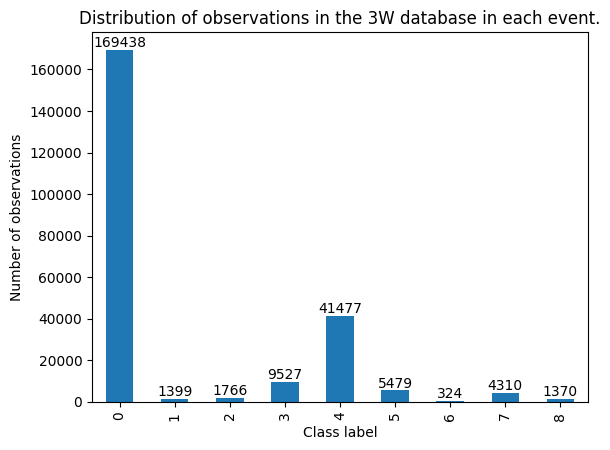

In [ ]:
# Showing the class imbalance between classes
ax = df1.pivot_table(index='class', aggfunc='size').plot(kind='bar')
# annotate
ax.bar_label(ax.containers[0])
ax.set(xlabel='Class label', ylabel='Number of observations', title = "Distribution of observations in the 3W database in each event.")

In [ ]:
print(df1["class"].value_counts())

0    169438
4     41477
3      9527
5      5479
7      4310
2      1766
1      1399
8      1370
6       324
Name: class, dtype: int64


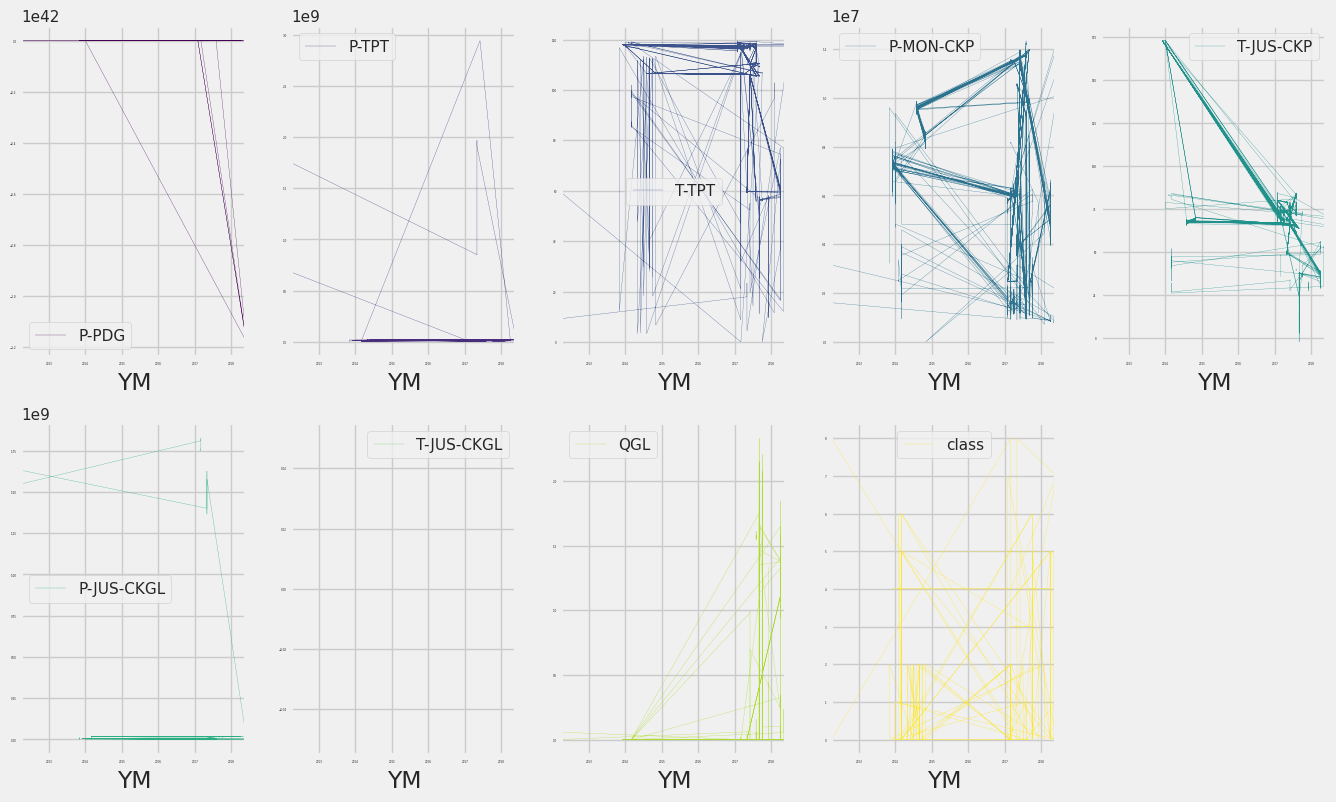

In [ ]:
# Combined dataset visualization

df2 = df1.copy()
df2['date'] = df2['timestamp'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
df2['YM'] = pd.to_datetime(df2['date']).dt.to_period('M')
df3 = df2.copy().set_index("YM")
df3 = df3.drop("timestamp", axis =1)
df3.plot(subplots=True,
          figsize=(15,9),
          layout=(2,5), 
          sharex=False, 
          sharey=False, 
          colormap='viridis', 
          fontsize=2, 
          legend=True, 
          linewidth=0.2)

plt.show()

In [ ]:
df1.shape

(235090, 10)

In [ ]:
df1 = df1.set_index("timestamp")

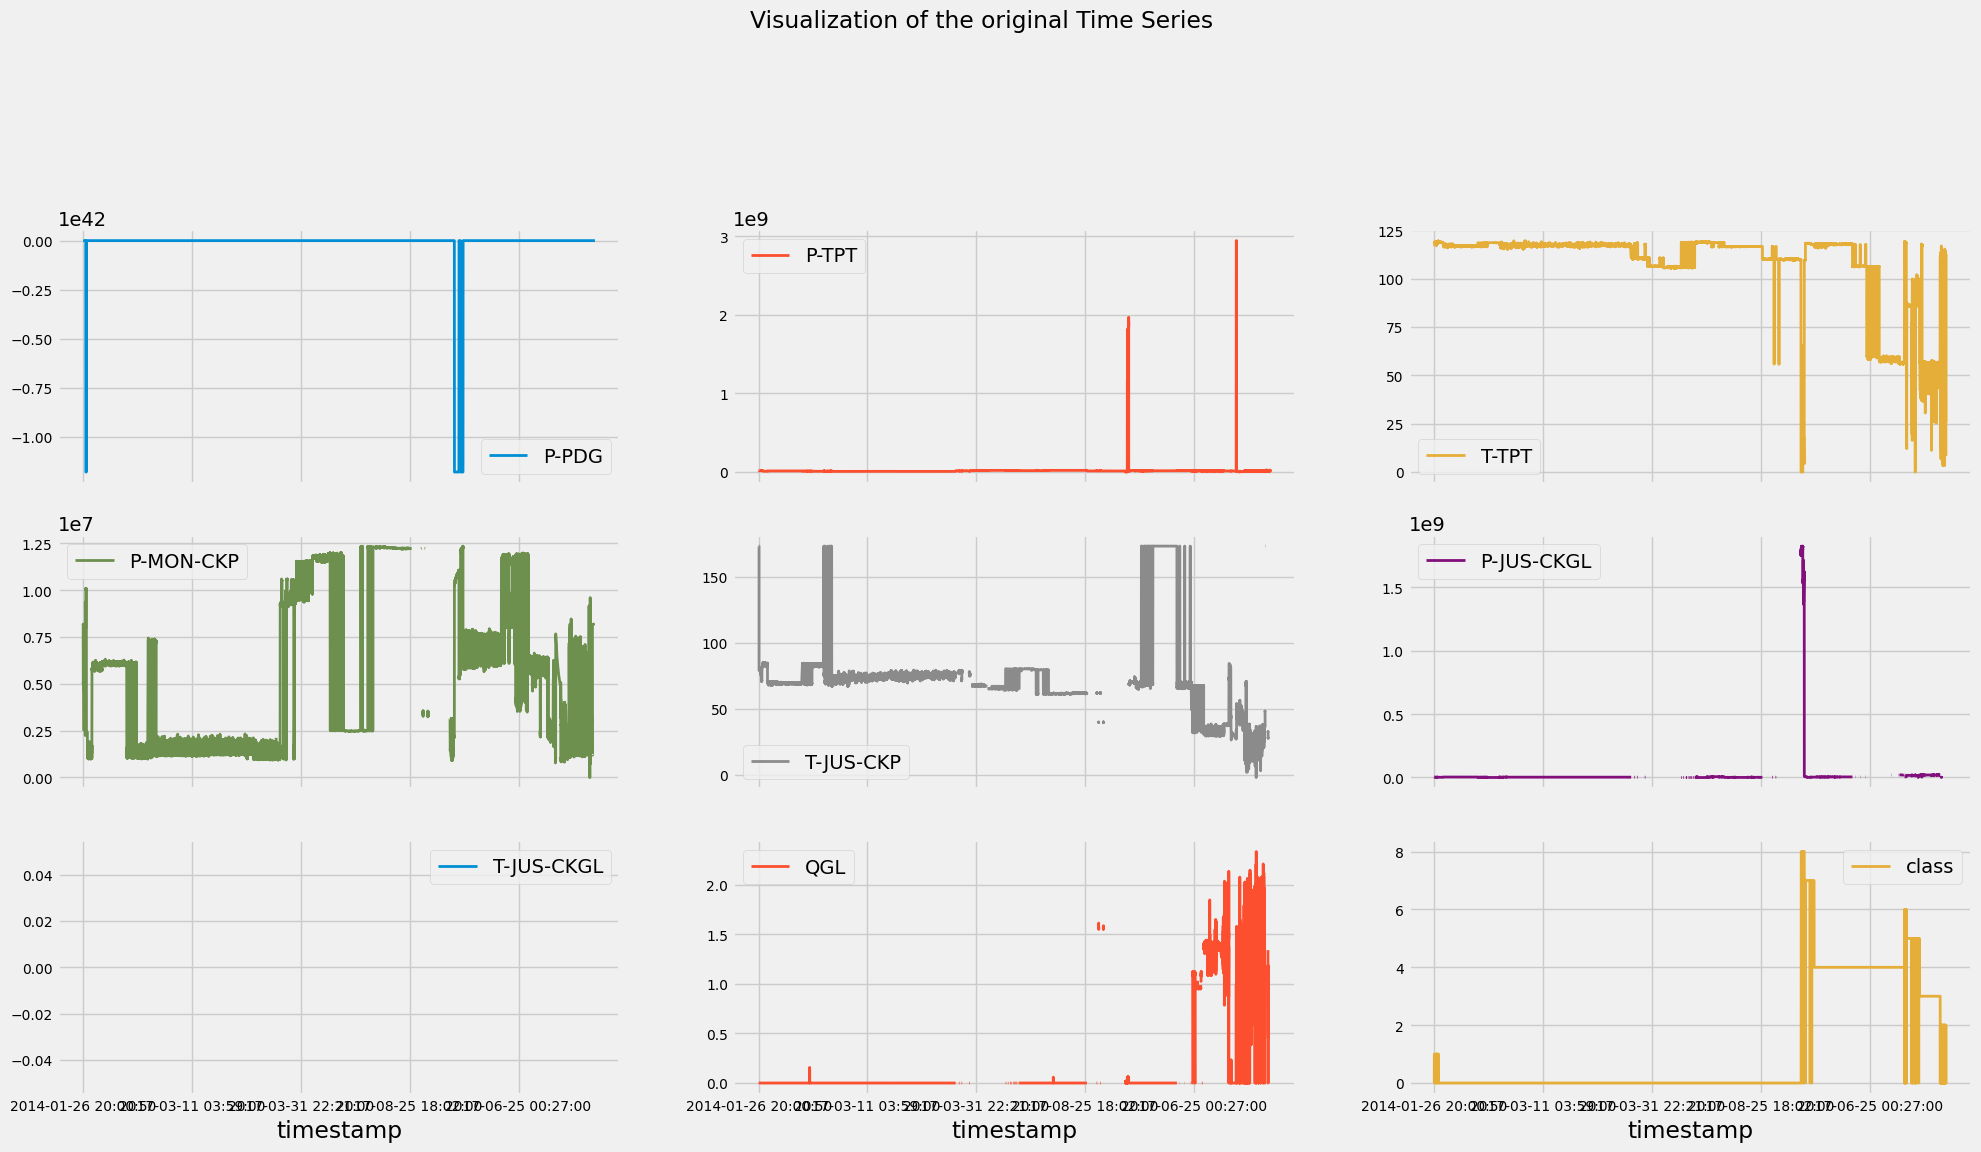

In [ ]:
# Plot the original combined time series
plt.style.use('fivethirtyeight')
df1.plot(subplots=True,
                  layout=(6, 3),
                  figsize=(22,22),
                  fontsize=10, 
                  linewidth=2, 
                  title='Visualization of the original Time Series')
plt.show()

Text(0.5, 0.98, 'All features Box Plots')

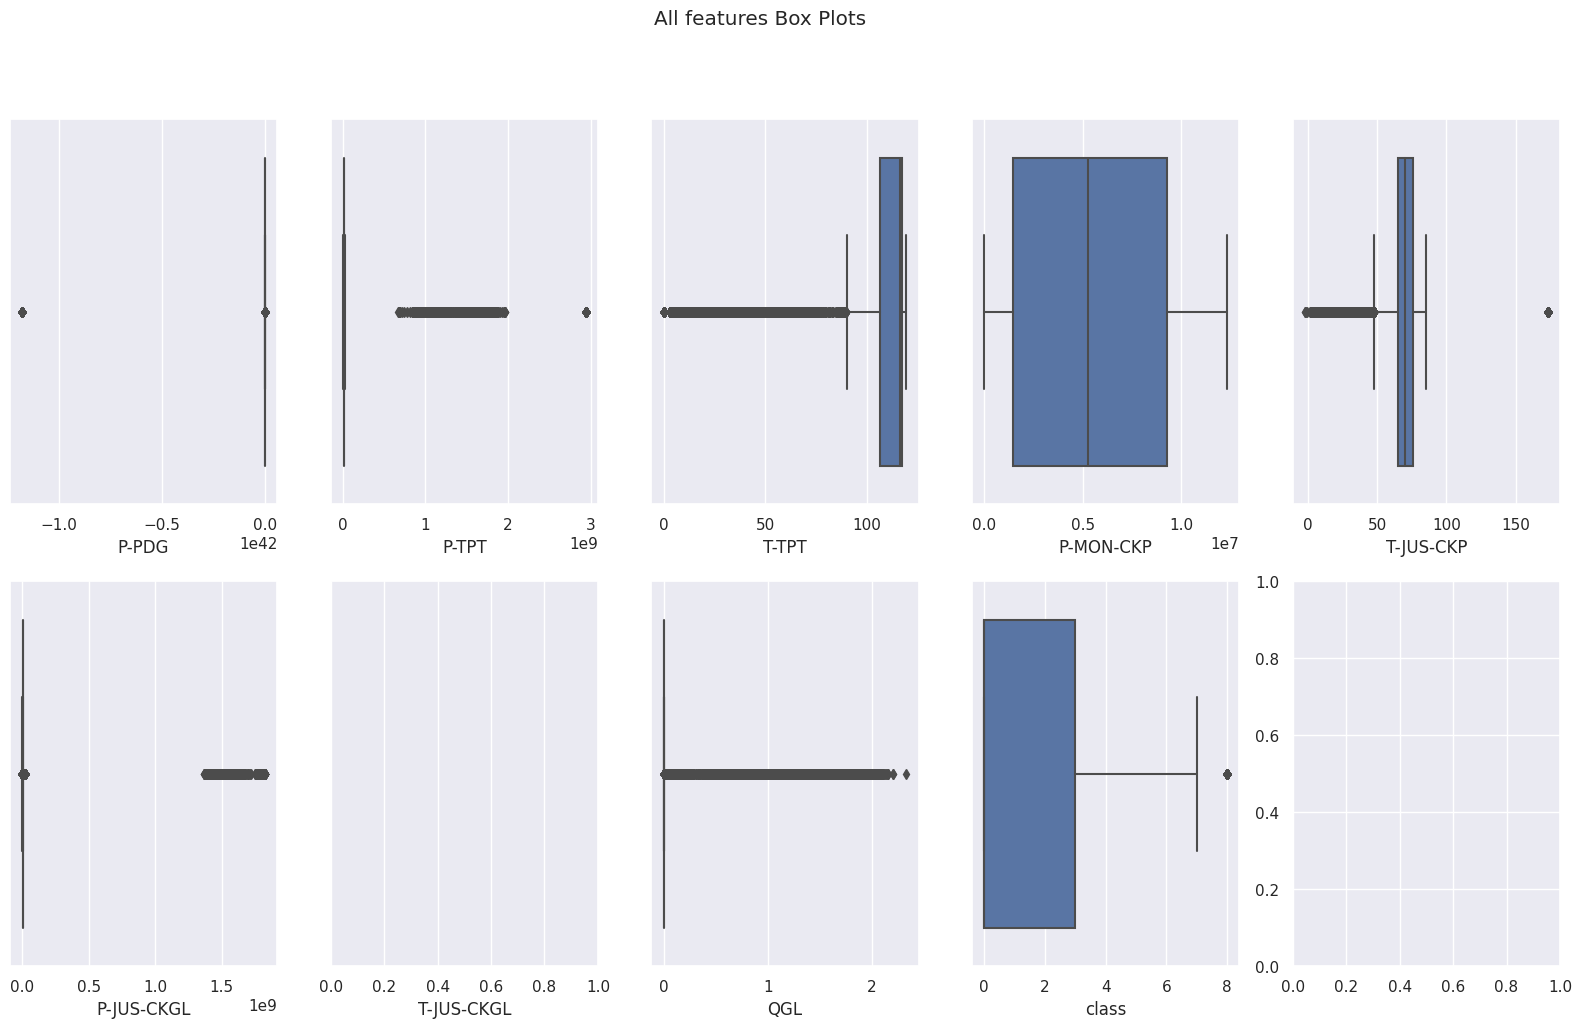

In [ ]:
# All features Box Plots in one figure

from math import ceil
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(df1.columns) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), df1.columns): 
    sns.boxplot(x=df1[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "All features Box Plots"

plt.suptitle(title)

In [ ]:
df1[["P-PDG", "P-TPT", "T-TPT", "P-MON-CKP", "T-JUS-CKP", "P-JUS-CKGL", "T-JUS-CKGL", "QGL", "class"]].describe(datetime_is_numeric=True).T

count          mean           std           min           25%  \
P-PDG       234976.0 -1.770857e+40  1.434736e+41 -1.180116e+42  0.000000e+00   
P-TPT       234958.0  2.046781e+07  1.128404e+08  0.000000e+00  8.757864e+06   
T-TPT       234962.0  1.069817e+02  2.184876e+01  0.000000e+00  1.065633e+02   
P-MON-CKP   216321.0  5.395788e+06  4.099006e+06 -8.317492e+03  1.467698e+06   
T-JUS-CKP   206626.0  7.377715e+01  3.114514e+01 -2.020000e+00  6.495565e+01   
P-JUS-CKGL  168932.0  1.906272e+07  1.585924e+08 -4.976717e+05  2.313628e+06   
T-JUS-CKGL       0.0           NaN           NaN           NaN           NaN   
QGL         180461.0  1.588380e-01  4.339517e-01  0.000000e+00  0.000000e+00   
class       235090.0  1.148024e+00  1.951725e+00  0.000000e+00  0.000000e+00   

                     50%           75%           max  
P-PDG       0.000000e+00  2.557498e+07  3.100648e+09  
P-TPT       1.420660e+07  1.806961e+07  2.941990e+09  
T-TPT       1.166321e+02  1.175853e+02  1.196029e+02  
P-MON-CKP   5.281252e+06  9.273394e+06  1.235171e+07  
T-JUS-CKP   7.033961e+01  7.618665e+01  1.730961e+02  
P-JUS-CKGL  2.332524e+06  3.463976e+06  1.825247e+09  
T-JUS-CKGL           NaN           NaN           NaN  
QGL         0.000000e+00  0.000000e+00  2.332980e+00  
class       0.000000e+00  3.000000e+00  8.000000e+00

In [ ]:
df2 = df1.copy()
df2['class'] = df2['class'].astype('category')

In [ ]:
# Remove outliers
# disable chained assignments
pd.options.mode.chained_assignment = None 

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.1,0.9]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

df_out=cap_data(df2)

capping the  P-PDG
capping the  P-TPT
capping the  T-TPT
capping the  P-MON-CKP
capping the  T-JUS-CKP
capping the  P-JUS-CKGL
capping the  T-JUS-CKGL
capping the  QGL
capping the  class


In [ ]:
df2.describe().T

count          mean           std           min           25%  \
P-PDG       234976.0  1.175389e+07  1.658043e+07  0.000000e+00  0.000000e+00   
P-TPT       234958.0  1.425393e+07  4.581790e+06  8.214859e+06  8.757864e+06   
T-TPT       234962.0  1.079804e+02  1.845928e+01  5.869200e+01  1.065633e+02   
P-MON-CKP   216321.0  5.374298e+06  4.033906e+06  1.281915e+06  1.467698e+06   
T-JUS-CKP   206626.0  6.788977e+01  1.342959e+01  3.730261e+01  6.495565e+01   
P-JUS-CKGL  168932.0  3.969675e+06  4.710041e+06 -1.378244e+05  2.313628e+06   
T-JUS-CKGL       0.0           NaN           NaN           NaN           NaN   
QGL         180461.0  1.298616e-01  3.494531e-01  0.000000e+00  0.000000e+00   

                     50%           75%           max  
P-PDG       0.000000e+00  2.557498e+07  4.485805e+07  
P-TPT       1.420660e+07  1.806961e+07  2.095085e+07  
T-TPT       1.166321e+02  1.175853e+02  1.184876e+02  
P-MON-CKP   5.281252e+06  9.273394e+06  1.191332e+07  
T-JUS-CKP   7.033961e+01  7.618665e+01  8.328982e+01  
P-JUS-CKGL  2.332524e+06  3.463976e+06  1.657084e+07  
T-JUS-CKGL           NaN           NaN           NaN  
QGL         0.000000e+00  0.000000e+00  1.095110e+00

Text(0.5, 0.98, 'All features Box Plots')

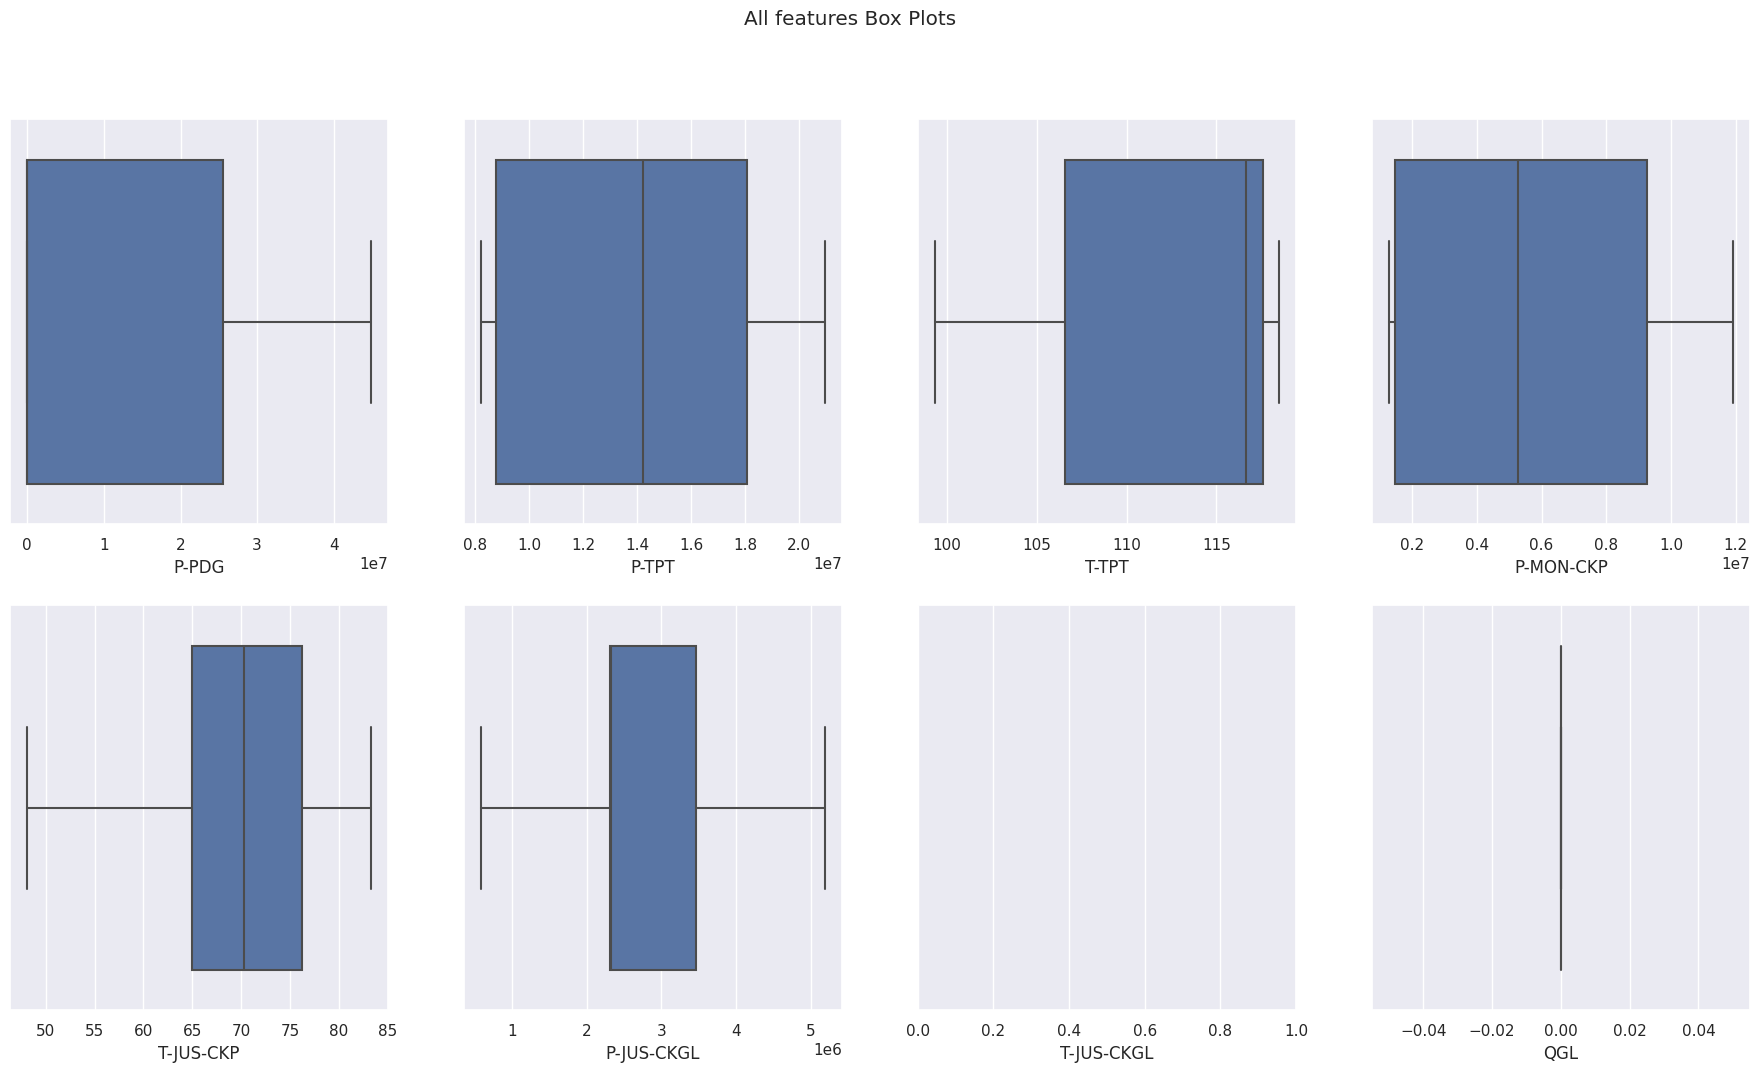

In [ ]:
# All features Box Plots in one figure

df_plot = df_out.loc[:, df_out.columns != 'class']

from math import ceil
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(df_plot.columns) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), df_plot.columns): 
    sns.boxplot(x=df_plot[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "All features Box Plots"

plt.suptitle(title)

<Axes: >

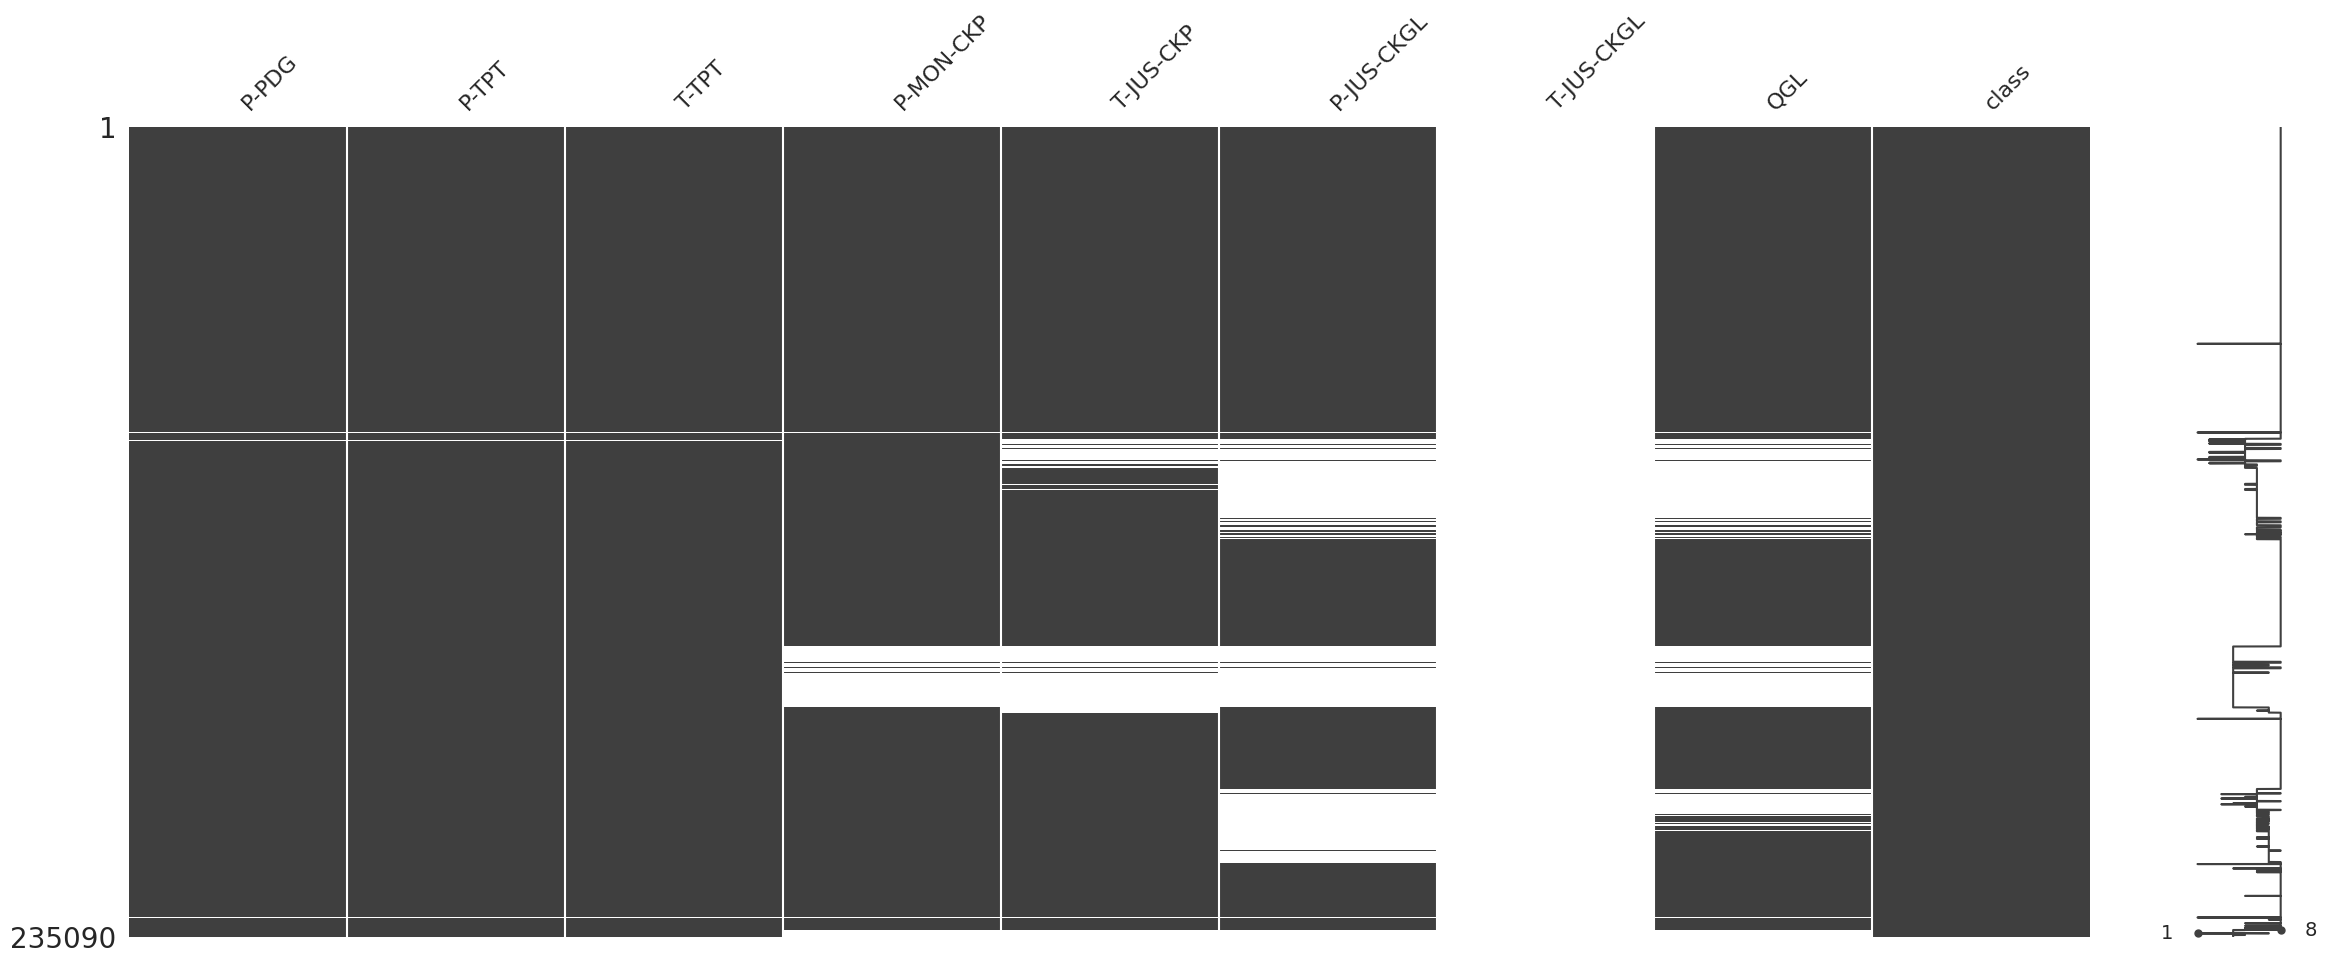

In [ ]:
# Discover frequencies of missing data visually
matrix(df_out)

In [ ]:
# Dropping T-JUS-CKGL and QGL
df2 = df_out.drop(columns=['T-JUS-CKGL', "QGL"])

<Axes: >

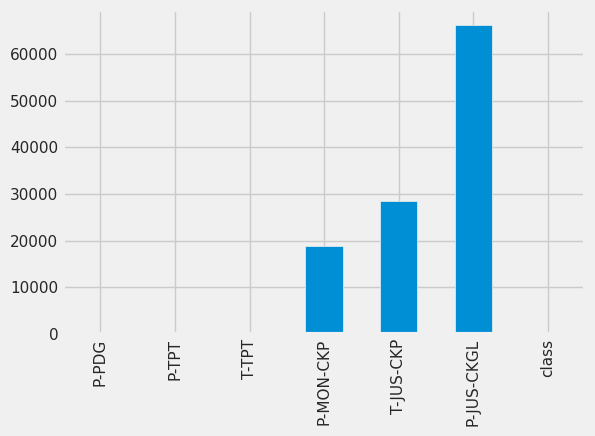

In [ ]:
# Find number of empty/NA values in each column
df2.isna().sum().plot(kind="bar", figsize=(6, 4))

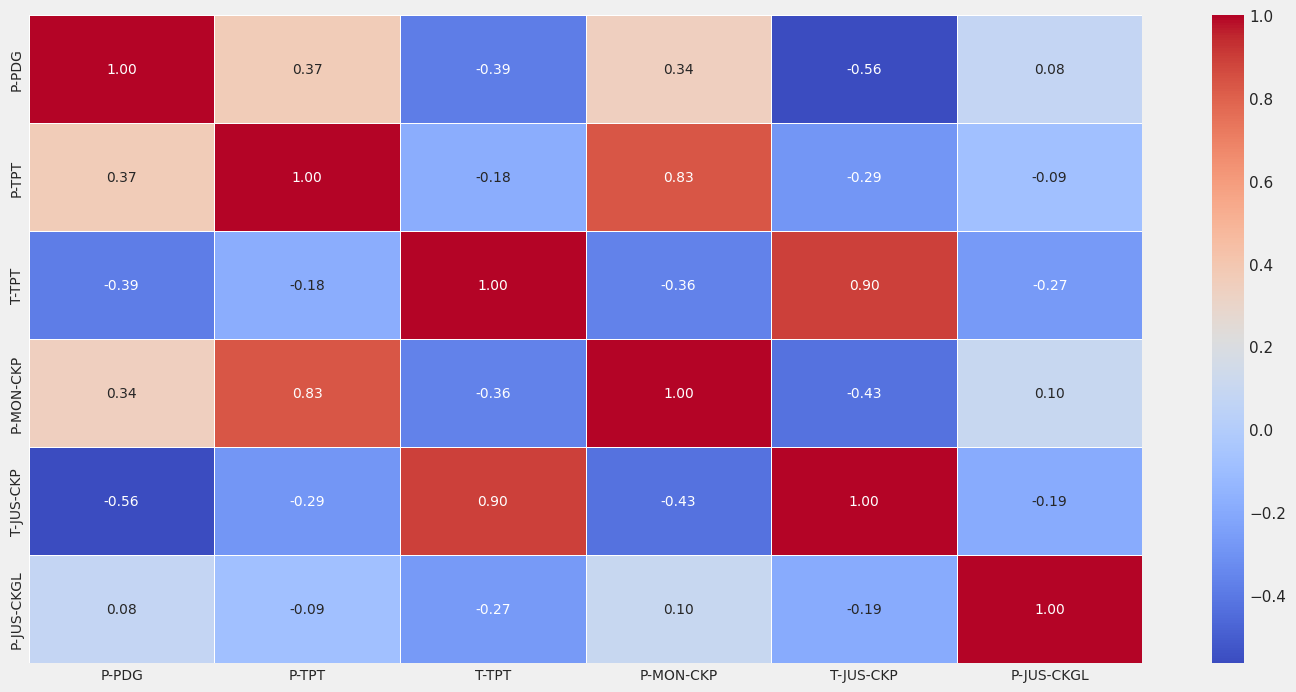

In [ ]:
# A heatmap visualization of the correlation matrix
corr_matrix = df2.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Filling in missing values with the next observed value
df2.fillna(method='ffill', inplace = True)

<Axes: >

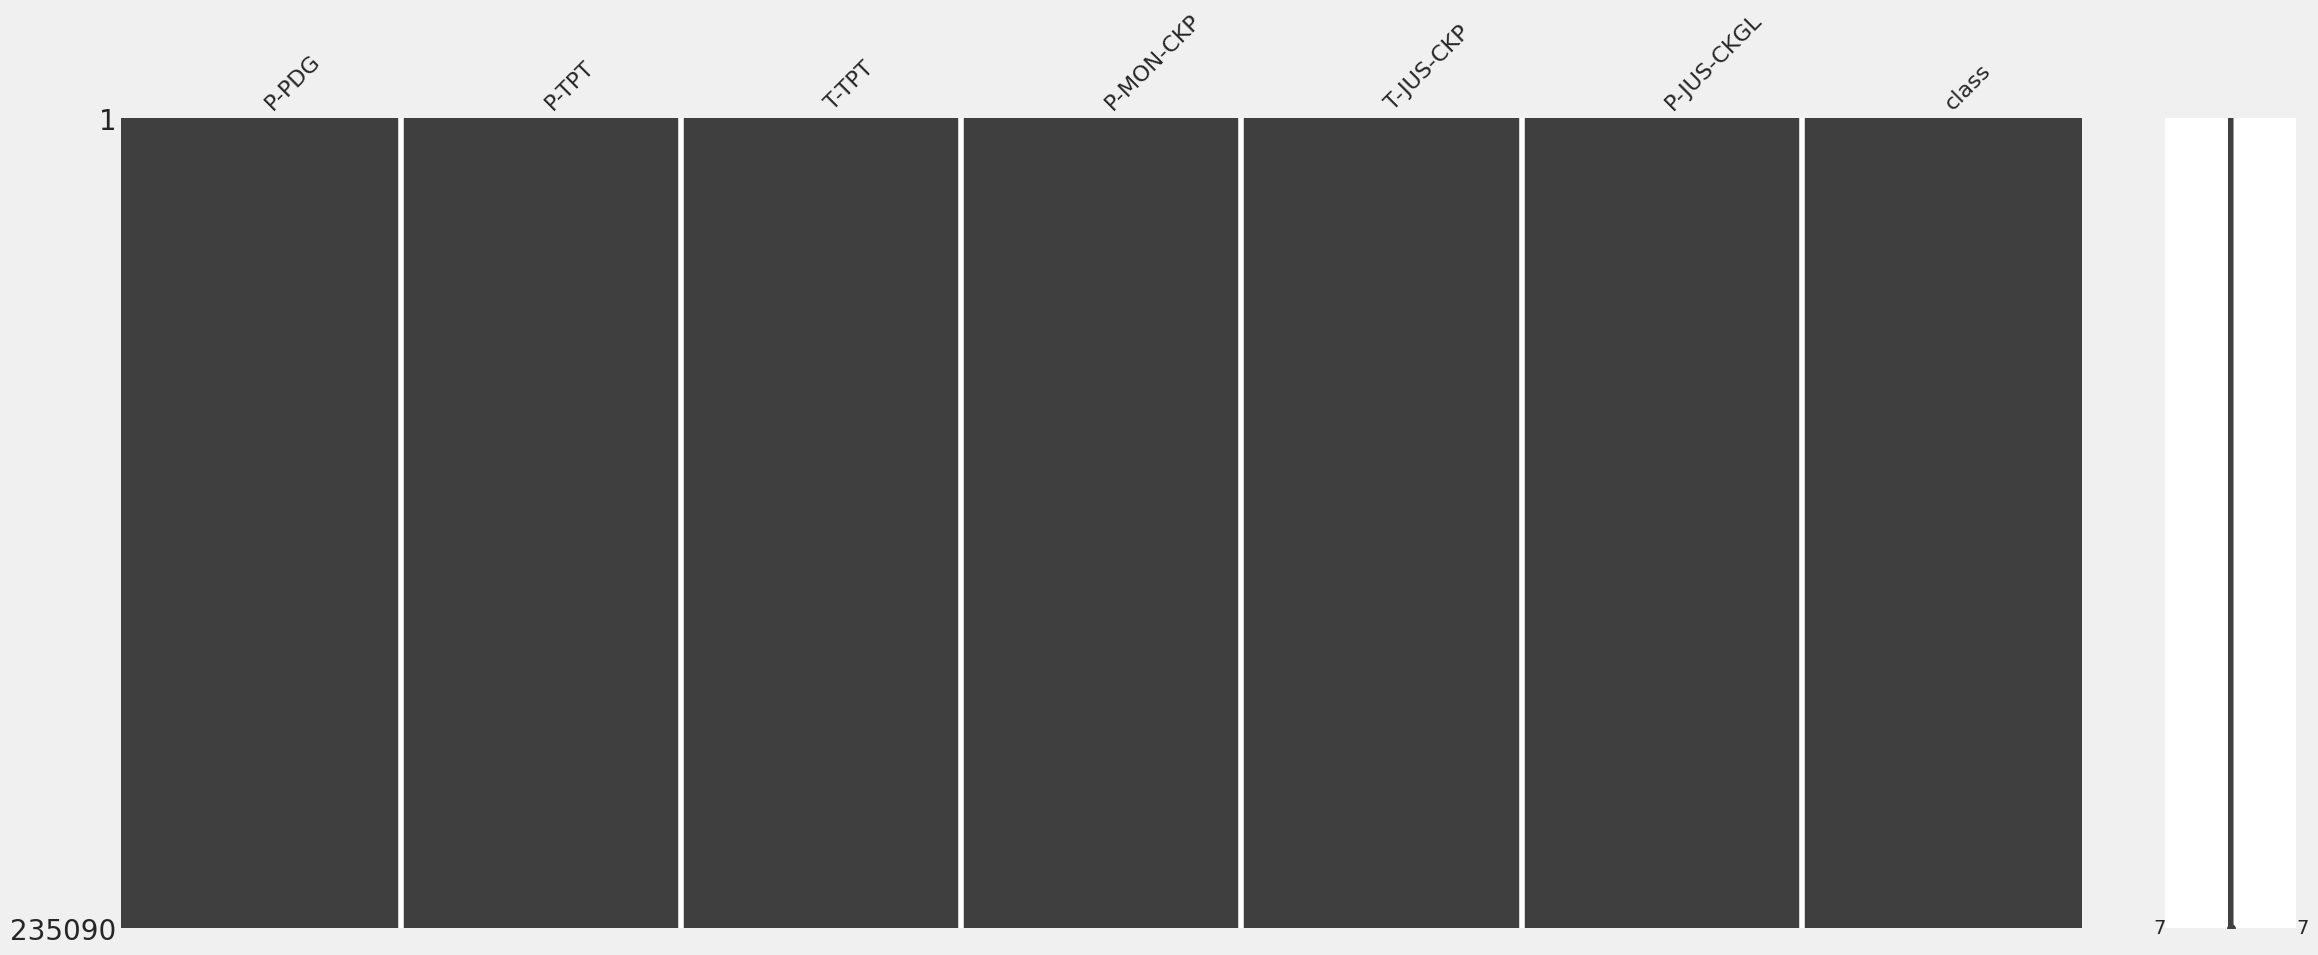

In [ ]:
matrix(df2)

In [ ]:
# Find number of empty/NA values in each column
df2.isna().sum()

P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
class         0
dtype: int64

<Axes: xlabel='T-JUS-CKP', ylabel='Density'>

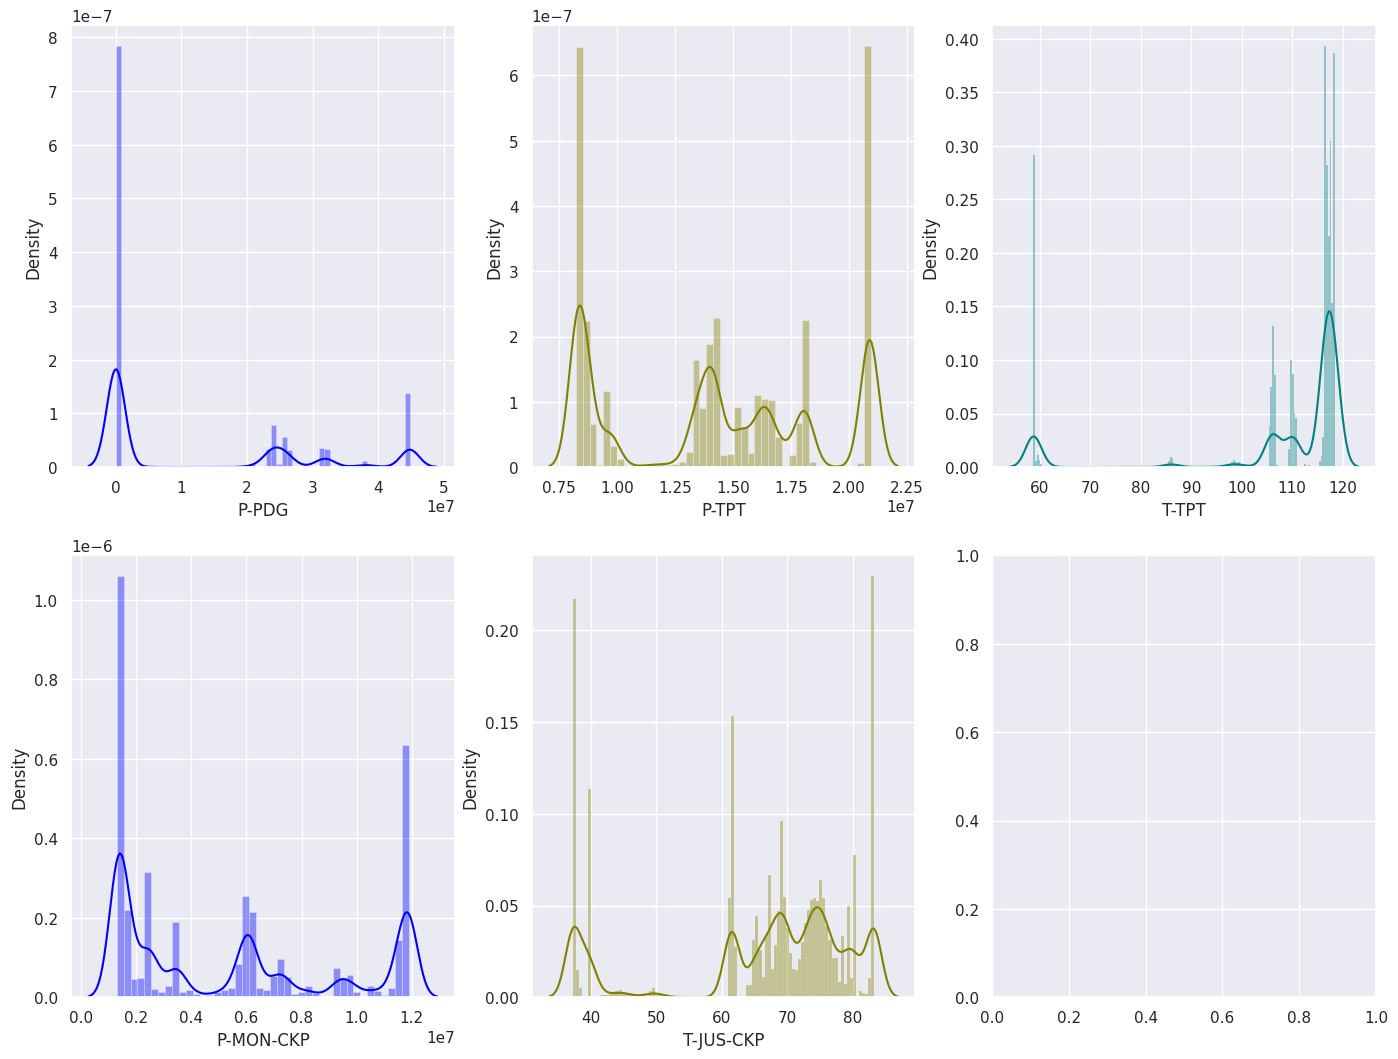

In [ ]:
# Histogram - Distributions of continuous variables
sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(15, 12), sharex=False)
sns.histplot(df2['P-PDG'], color="blue", ax=axes[0, 0], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
sns.histplot(df2['P-TPT'], color="olive", ax=axes[0, 1], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
sns.histplot(df2['T-TPT'], color="teal", ax=axes[0, 2], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
sns.histplot(df2['P-MON-CKP'], color="blue", ax=axes[1, 0], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
sns.histplot(df2['T-JUS-CKP'], color="olive", ax=axes[1, 1], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
# sns.histplot(df2['class'], color="teal", ax=axes[1, 2], kde = True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))

<Axes: xlabel='class', ylabel='T-JUS-CKP'>

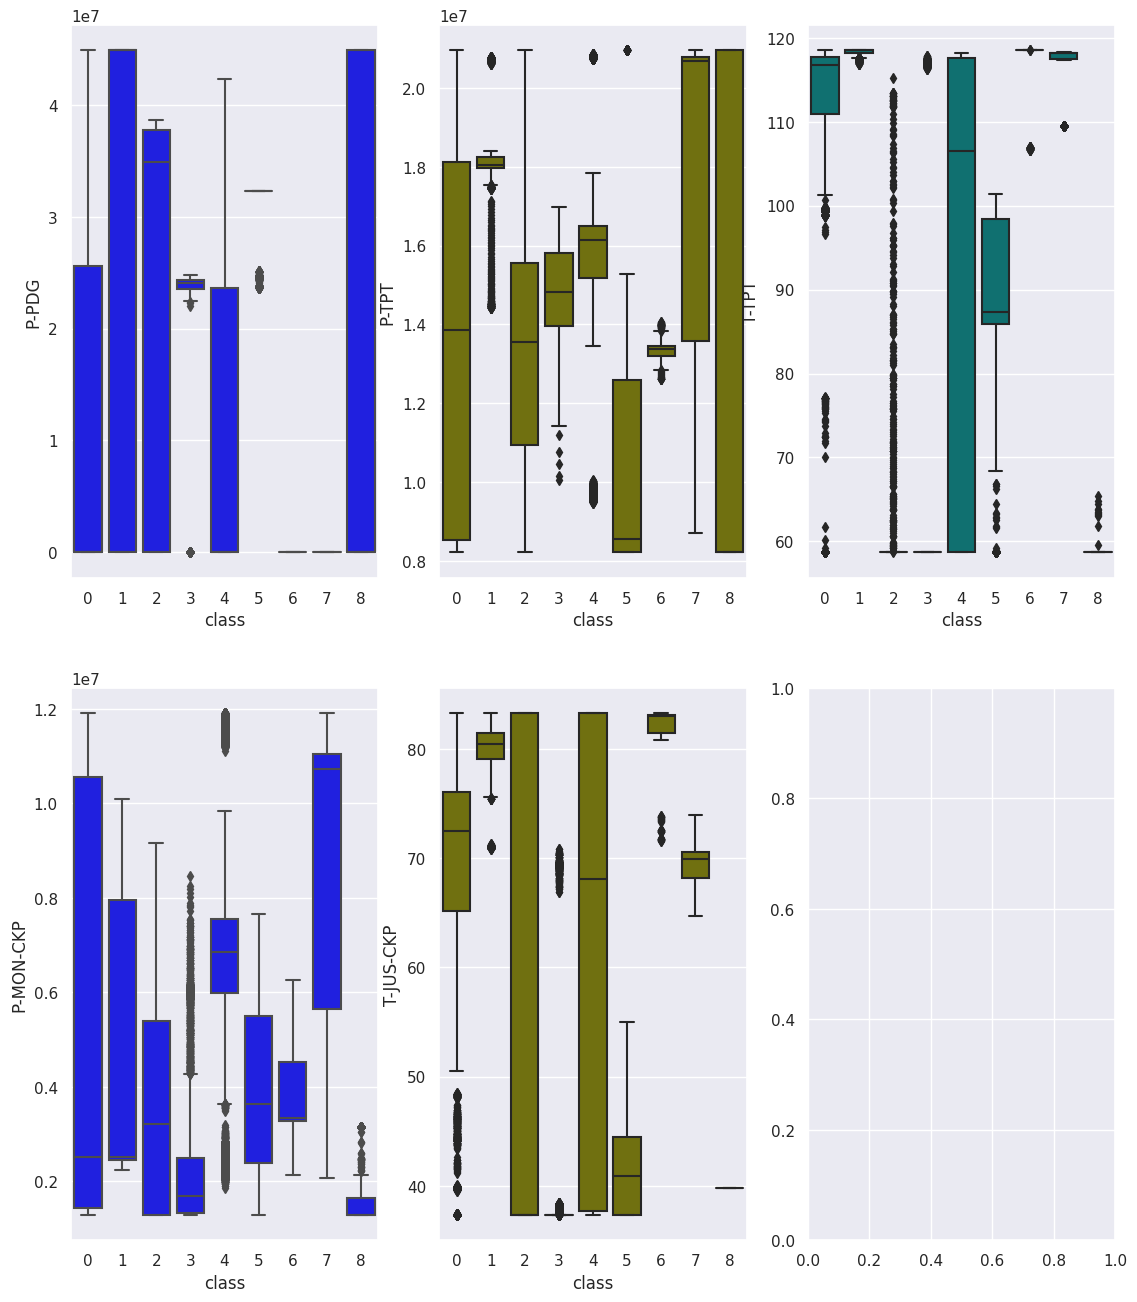

In [ ]:
# Box Plots of the final preprocessed data
f, axes = plt.subplots(2, 3, figsize=(12, 15), sharex=False)
sns.boxplot(df2,  x = 'class',    y = 'P-PDG', color="blue", ax=axes[0, 0])
sns.boxplot(df2, x = 'class', y = 'P-TPT', color="olive", ax=axes[0, 1])
sns.boxplot(df2, x = 'class', y = 'T-TPT', color="teal", ax=axes[0, 2])
sns.boxplot(df2, x = 'class', y = 'P-MON-CKP', color="blue", ax=axes[1, 0])
sns.boxplot(df2, x = 'class', y = 'T-JUS-CKP', color="olive", ax=axes[1, 1])

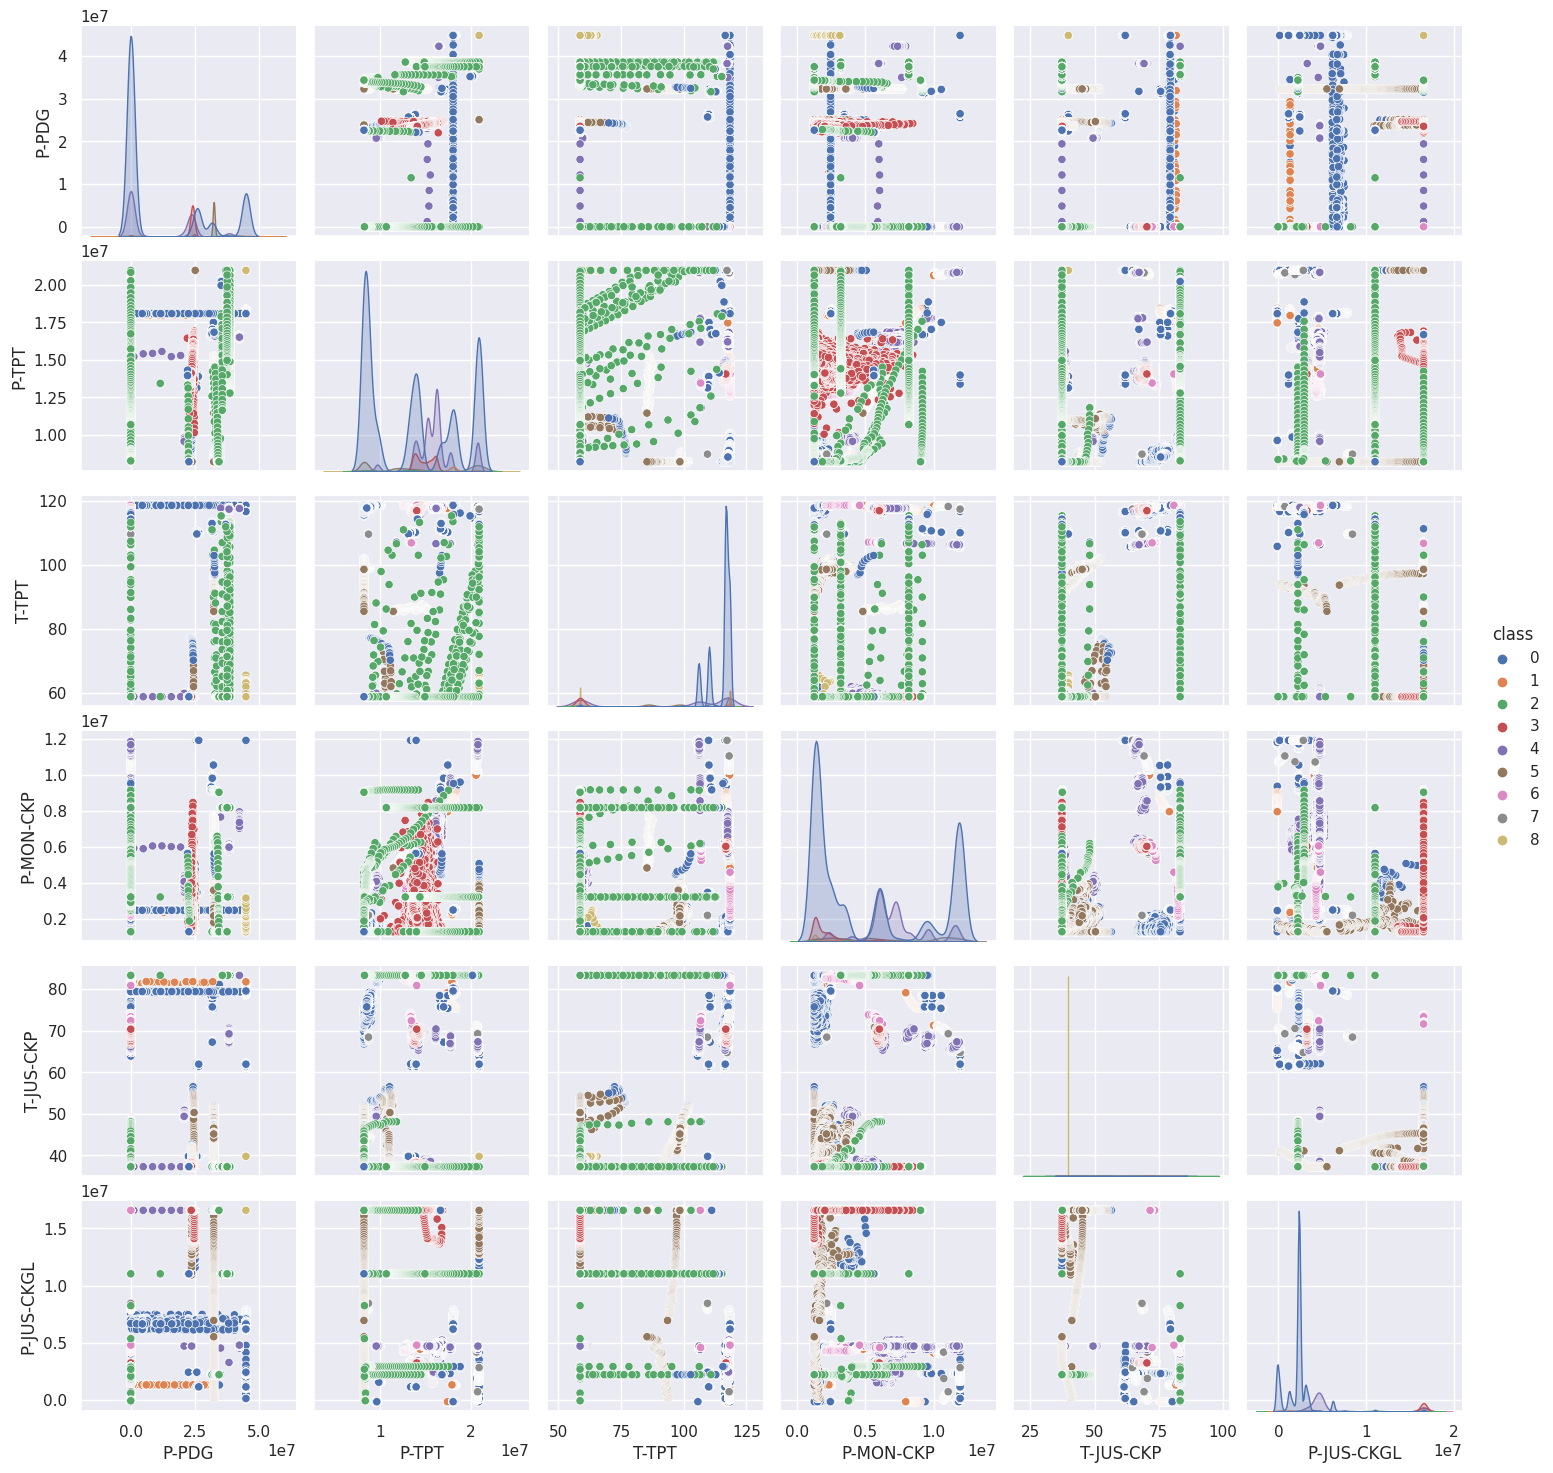

In [ ]:
# Relationship between variables and classes

#df2 =df1.copy()
df2= df2.reset_index()
#df2['class'] = df2['class'].astype('category')
Columns = list(df2.columns)
sns.pairplot(data = df2[Columns[:8]].drop(['timestamp'], axis="columns"), 
              hue = "class")

In [ ]:
df2.to_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index = True)

In [ ]:
#df2 = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [ ]:
# Splitting the dataset
X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [ ]:
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (164563, 6)
Shape of Training y: (164563,)
Shape of Test X: (70527, 6)
Shape of Test y: (70527,)


Without SMOTE

In [ ]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [ ]:
T = 30  # timesteps window

X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
    X_train_1.append(train_scaled.iloc[i:i+T].values)
    y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
    X_test_1.append(test_scaled.iloc[i:i+T].values)
    y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  

print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

Train data dimensions: (164534, 30, 6), (164534, 1)
Test data dimensions: (70498, 30, 6), (70498, 1)


In [ ]:
# LSTM model with 2 stucked LSTM layers each 10 hidden units and activation function tanh

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="tanh", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='tanh'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 10)            680       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 164s 29ms/step - loss: 0.5019 - accuracy: 0.8506 - val_loss: 0.3286 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 162s 29ms/step - loss: 0.2914 - accuracy: 0.9184 - val_loss: 0.2717 - val_accuracy: 0.9279 - lr

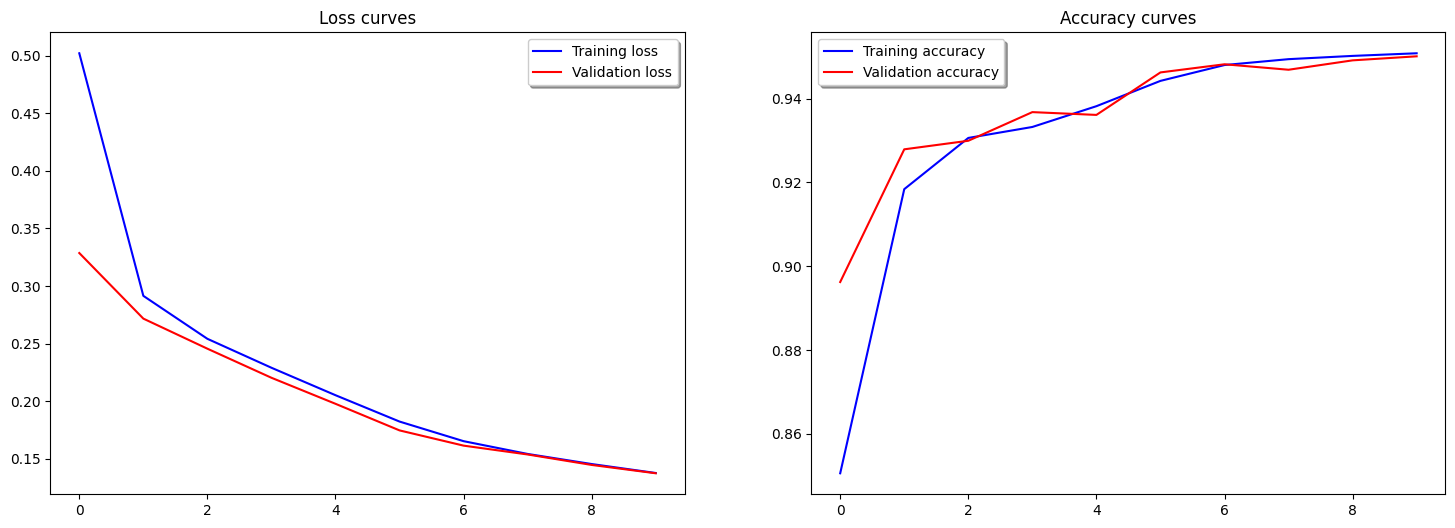

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)
#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 15s 7ms/step


<Axes: >

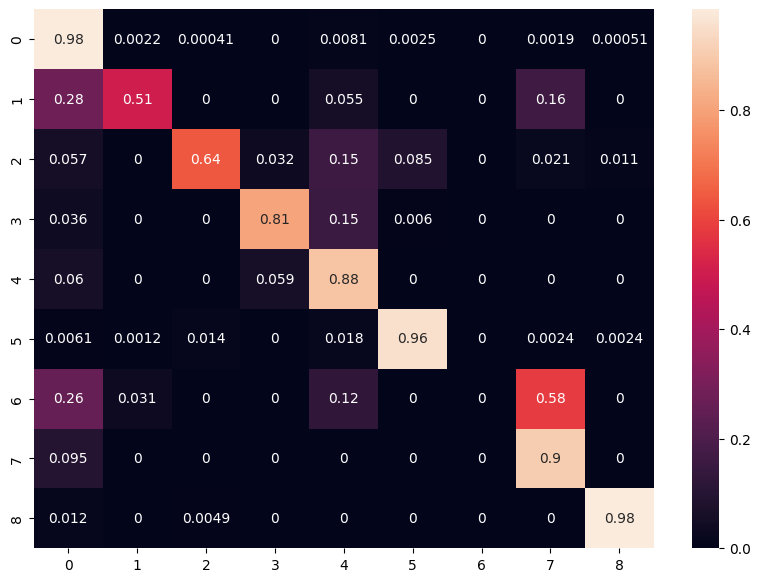

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9501120599165934
Confusion Matrix: 
 [[50021   110    21     0   410   125     0    97    26]
 [  116   213     0     0    23     0     0    68     0]
 [   30     0   339    17    82    45     0    11     6]
 [  104     0     0  2302   432    17     0     0     0]
 [  744     0     0   734 10962     0     0     0     0]
 [   10     2    23     0    30  1571     0     4     4]
 [   25     3     0     0    12     0     0    56     0]
 [  123     0     0     0     0     0     0  1170     0]
 [    5     0     2     0     0     0     0     0   403]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50810
           1       0.65      0.51      0.57       420
           2       0.88      0.64      0.74       530
           3       0.75      0.81      0.78      2855
           4       0.92      0.88      0.90     12440
           5       0.89      0.96      0.92      1644
           6

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# LSTM model with 2 stucked LSTM layers each 10 hidden units and activation function softmax

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="softmax", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='softmax'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 10)            680       
                                                                 
 lstm_7 (LSTM)               (None, 10)                840       
                                                                 
 dense_3 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 163s 29ms/step - loss: 0.8412 - accuracy: 0.7525 - val_loss: 0.5595 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 154s 28ms/step - loss: 0.5239 - accuracy: 0.8654 - val_loss: 0.5082 - val_accuracy: 0.8658 - lr

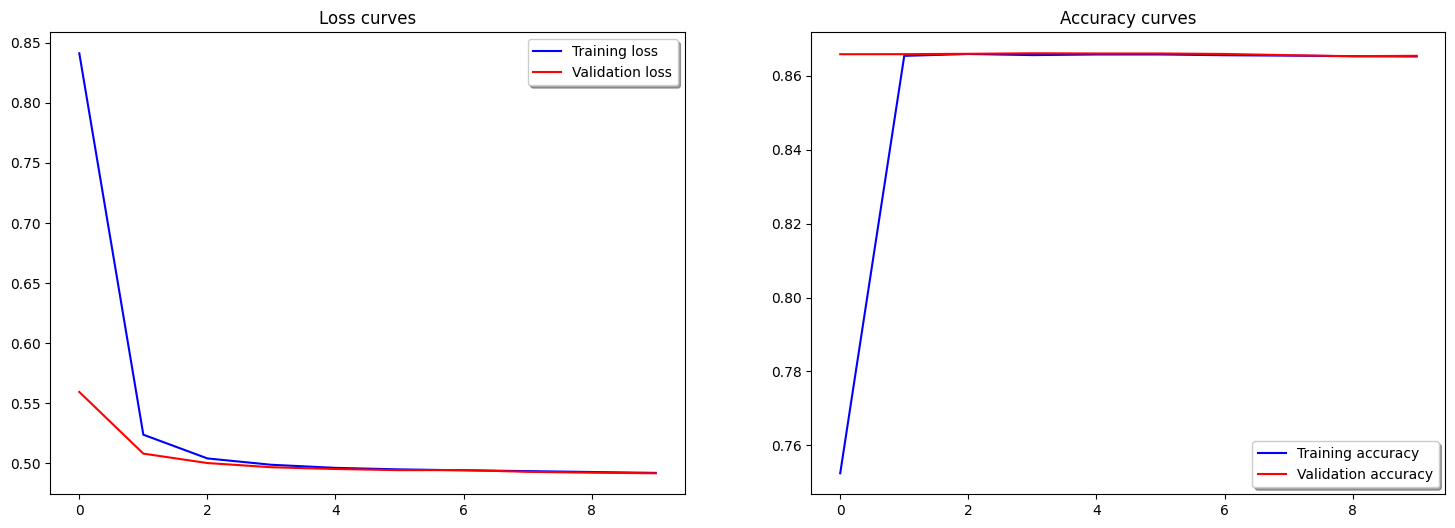

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

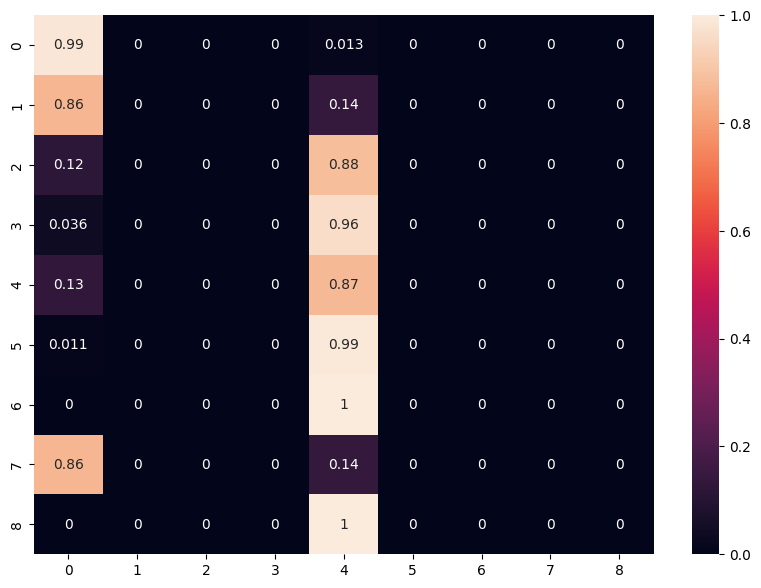

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.8653720672926891
Confusion Matrix: 
 [[50174     0     0     0   636     0     0     0     0]
 [  362     0     0     0    58     0     0     0     0]
 [   64     0     0     0   466     0     0     0     0]
 [  104     0     0     0  2751     0     0     0     0]
 [ 1607     0     0     0 10833     0     0     0     0]
 [   18     0     0     0  1626     0     0     0     0]
 [    0     0     0     0    96     0     0     0     0]
 [ 1116     0     0     0   177     0     0     0     0]
 [    0     0     0     0   410     0     0     0     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     50810
           1       0.00      0.00      0.00       420
           2       0.00      0.00      0.00       530
           3       0.00      0.00      0.00      2855
           4       0.64      0.87      0.73     12440
           5       0.00      0.00      0.00      1644
           6

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# LSTM model with 2 stucked LSTM layers and activation function LeakyReLU

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 10)            680       
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                                 
 dense_4 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 155s 28ms/step - loss: 0.4218 - accuracy: 0.8860 - val_loss: 0.2663 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 148s 27ms/step - loss: 0.2116 - accuracy: 0.9363 - val_loss: 0.1894 - val_accuracy: 0.9394 - lr

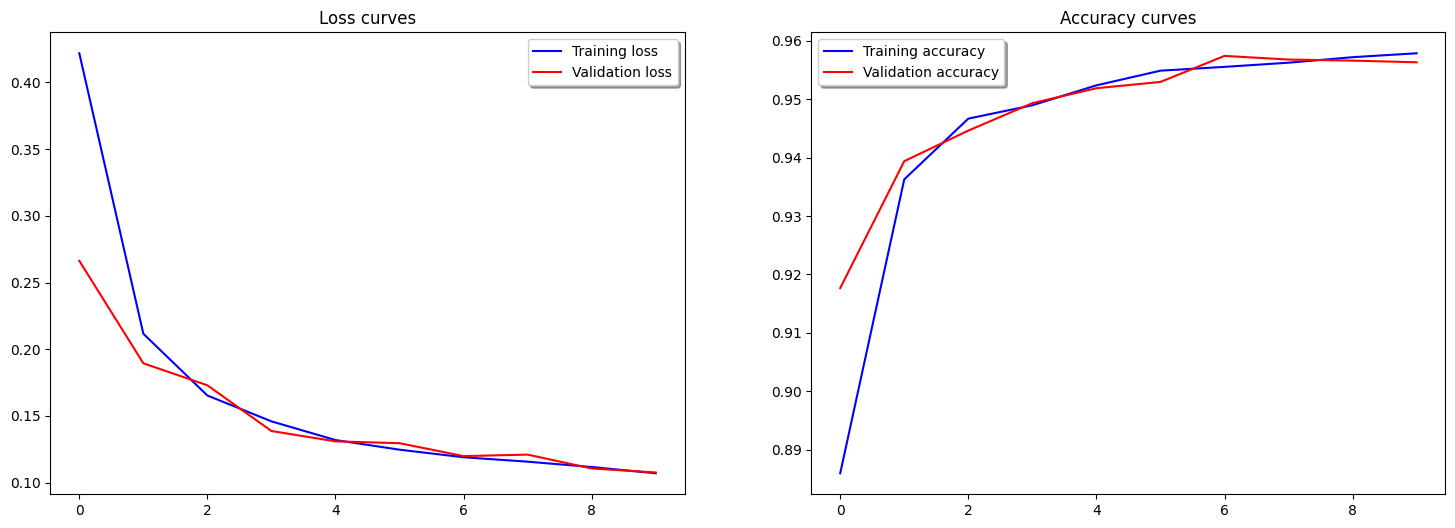

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 15s 6ms/step


<Axes: >

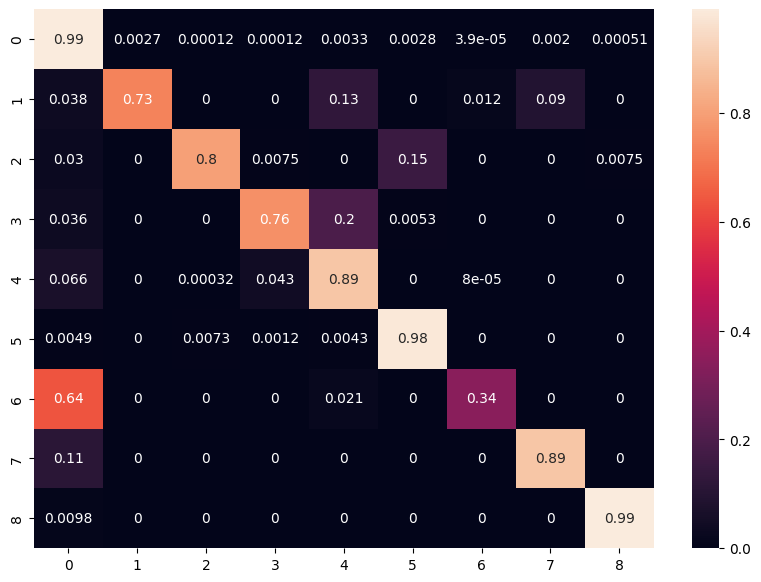

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9562966325285823
Confusion Matrix: 
 [[50221   137     6     6   168   142     2   102    26]
 [   16   308     0     0    53     0     5    38     0]
 [   16     0   424     4     0    82     0     0     4]
 [  104     0     0  2178   558    15     0     0     0]
 [  820     0     4   534 11081     0     1     0     0]
 [    8     0    12     2     7  1615     0     0     0]
 [   61     0     0     0     2     0    33     0     0]
 [  142     0     0     0     0     0     0  1151     0]
 [    4     0     0     0     0     0     0     0   406]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.69      0.73      0.71       420
           2       0.95      0.80      0.87       530
           3       0.80      0.76      0.78      2855
           4       0.93      0.89      0.91     12440
           5       0.87      0.98      0.92      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers and activation function relu

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_13 (LSTM)              (None, 10)                840       
                                                                 
 dense_6 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 148s 26ms/step - loss: 0.4127 - accuracy: 0.8745 - val_loss: 0.2465 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 140s 25ms/step - loss: 0.2003 - accuracy: 0.9370 - val_loss: 0.1714 - val_accuracy: 0.9456 - lr

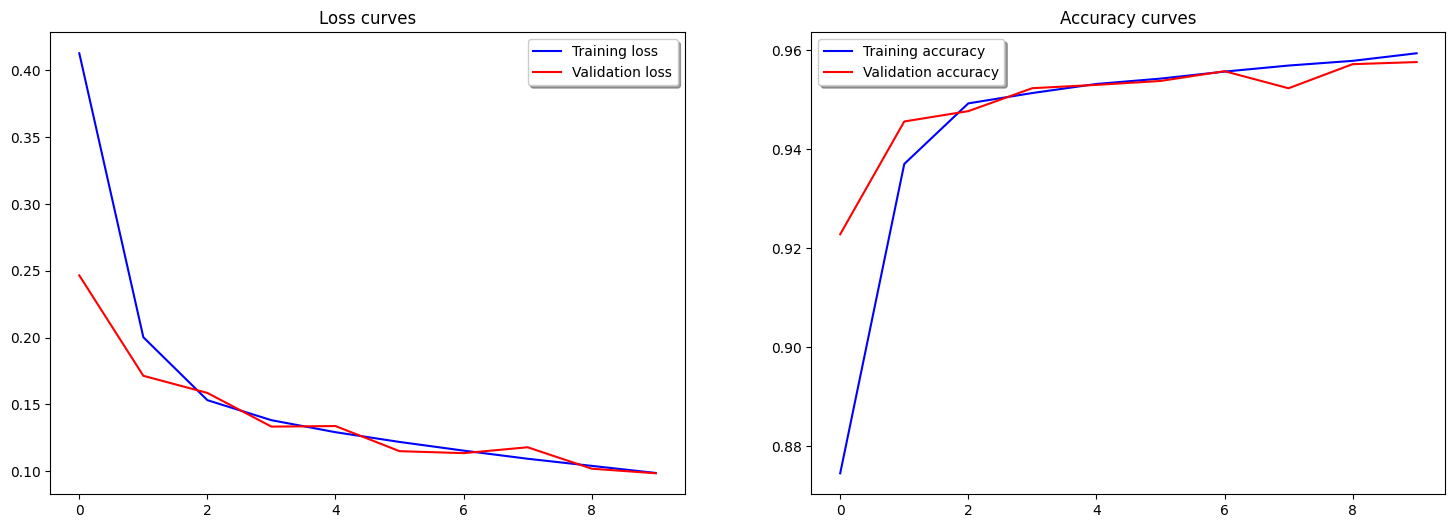

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 17s 7ms/step


<Axes: >

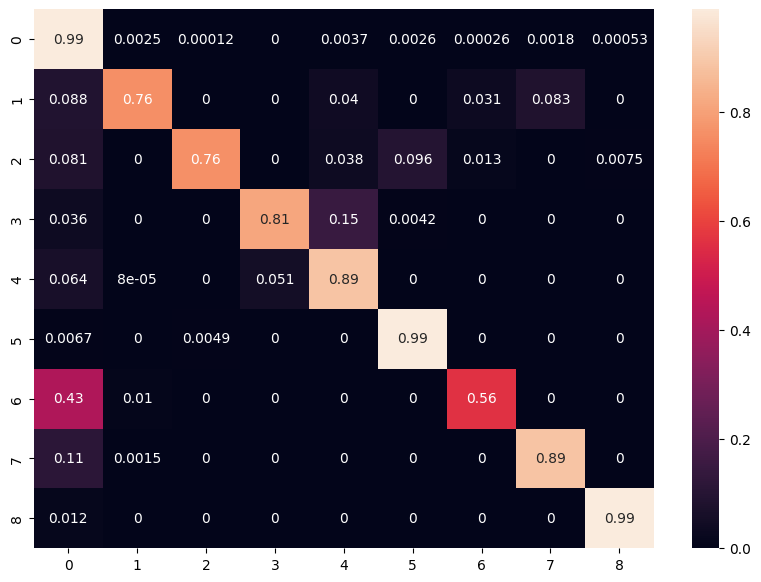

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9576016340889103
Confusion Matrix: 
 [[50227   129     6     0   186   130    13    92    27]
 [   37   318     0     0    17     0    13    35     0]
 [   43     0   405     0    20    51     7     0     4]
 [  102     0     0  2317   424    12     0     0     0]
 [  797     1     0   630 11012     0     0     0     0]
 [   11     0     8     0     0  1625     0     0     0]
 [   41     1     0     0     0     0    54     0     0]
 [  145     2     0     0     0     0     0  1146     0]
 [    5     0     0     0     0     0     0     0   405]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.71      0.76      0.73       420
           2       0.97      0.76      0.85       530
           3       0.79      0.81      0.80      2855
           4       0.94      0.89      0.91     12440
           5       0.89      0.99      0.94      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers, activation function relu and one Droupout layer

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(Dropout(rate=0.1))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 10)            680       
                                                                 
 dropout_5 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [=========================

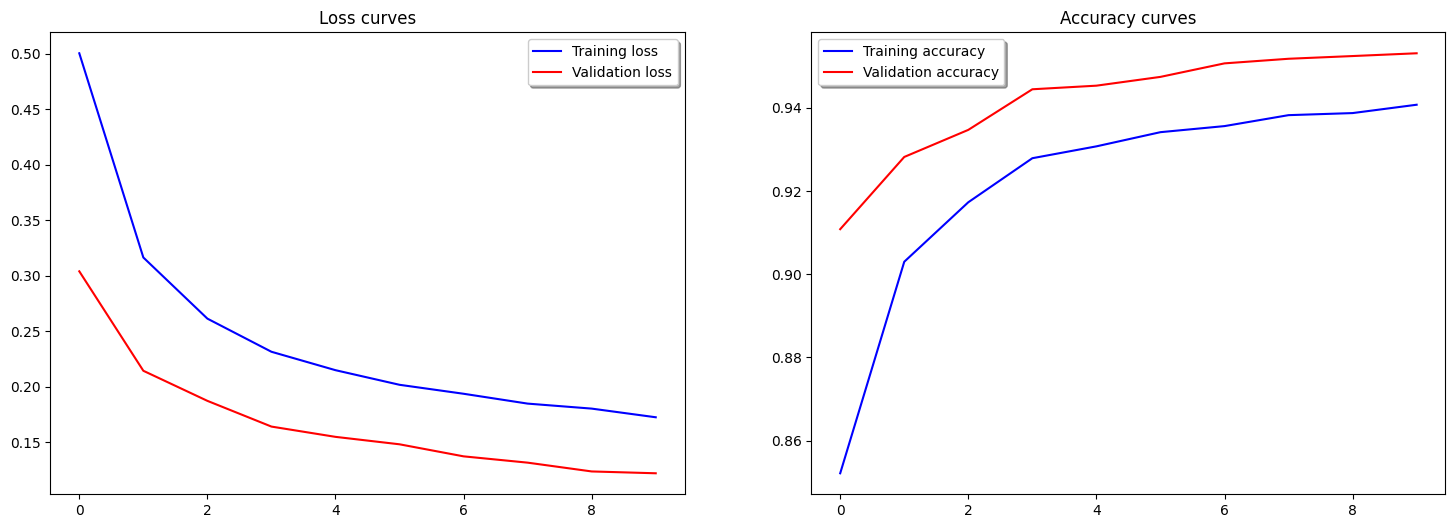

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 14s 6ms/step


<Axes: >

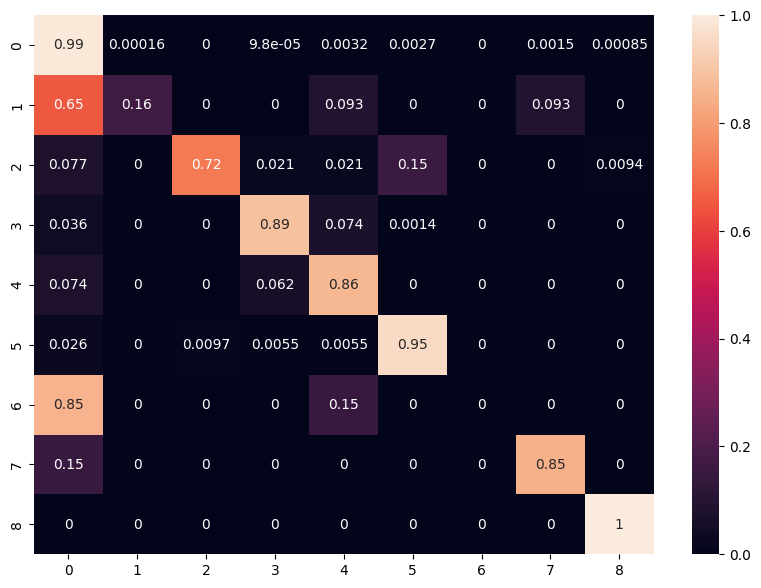

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9531050526256064
Confusion Matrix: 
 [[50381     8     0     5   161   137     0    75    43]
 [  273    69     0     0    39     0     0    39     0]
 [   41     0   381    11    11    81     0     0     5]
 [  104     0     0  2537   210     4     0     0     0]
 [  925     0     0   768 10747     0     0     0     0]
 [   43     0    16     9     9  1567     0     0     0]
 [   82     0     0     0    14     0     0     0     0]
 [  193     0     0     0     0     0     0  1100     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     50810
           1       0.90      0.16      0.28       420
           2       0.96      0.72      0.82       530
           3       0.76      0.89      0.82      2855
           4       0.96      0.86      0.91     12440
           5       0.88      0.95      0.91      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers and activation function LeakyReLU and 20 hidden units

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 20)            2160      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dense_1 (Dense)             (None, 9)                 189       
                                                                 
Total params: 5,629
Trainable params: 5,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 155s 28ms/step - loss: 0.3423 - accuracy: 0.9034 - val_loss: 0.2073 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 152s 28ms/step - loss: 0.1707 - accuracy: 0.9464 - val_loss: 0.1600 - val_accuracy: 0.9490 - lr

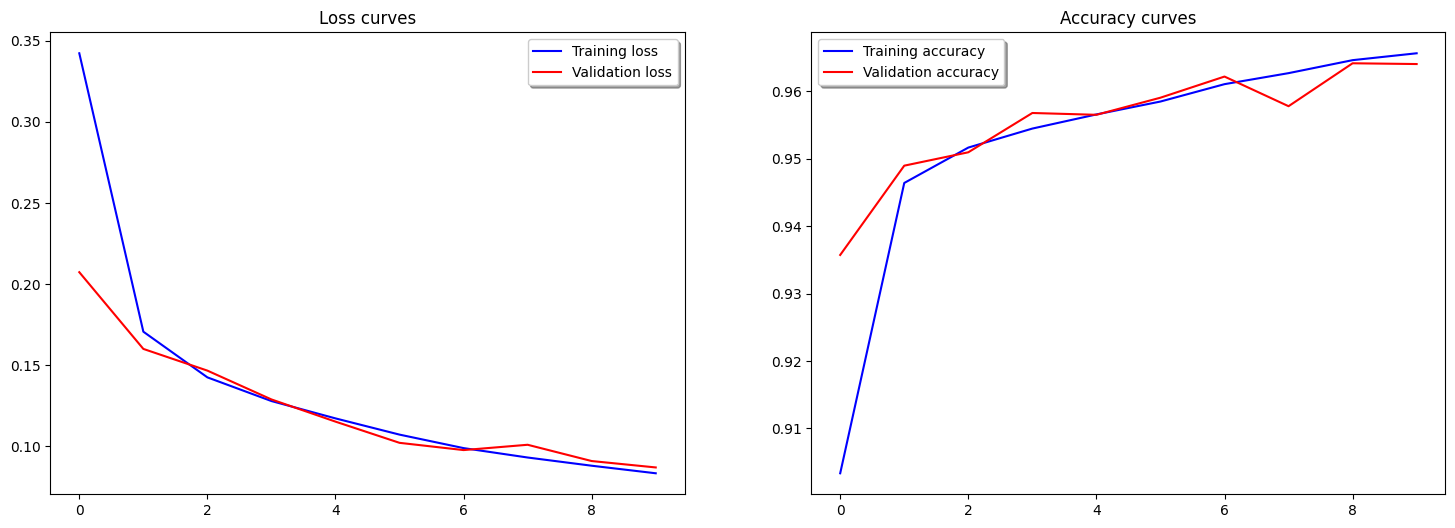

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

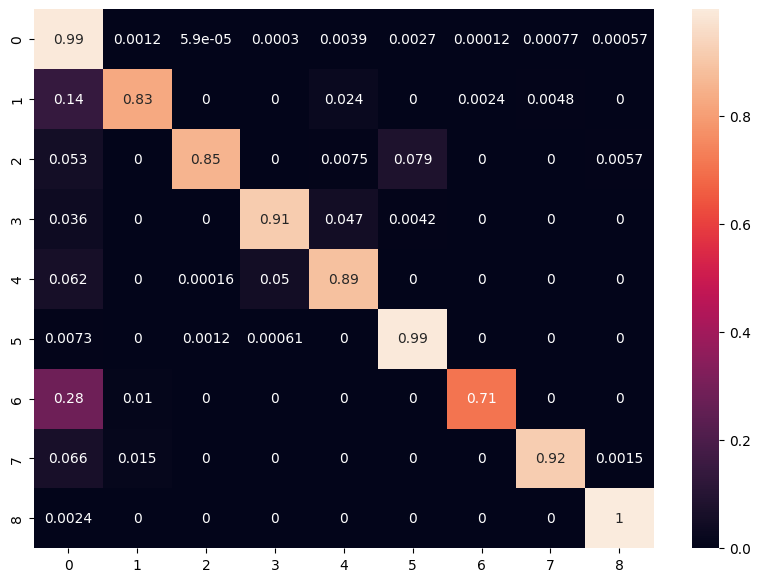

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.964069902692275
Confusion Matrix: 
 [[50284    81     3     9   206   141     0    55    31]
 [   74   333     0     0    12     0     1     0     0]
 [   19     0   476     3     1    26     0     1     4]
 [  104     0     0  2500   245     6     0     0     0]
 [  764     0     2   522 11152     0     0     0     0]
 [    6     0     3     0     0  1635     0     0     0]
 [   73     0     0     0     0     0    23     0     0]
 [   94    47     0     0     0     0     0  1152     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.72      0.79      0.76       420
           2       0.98      0.90      0.94       530
           3       0.82      0.88      0.85      2855
           4       0.96      0.90      0.93     12440
           5       0.90      0.99      0.95      1644
           6 

In [ ]:
# LSTM model with 2 stucked LSTM layers, activation function relu and 20 hidden units

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 30, 20)            2160      
                                                                 
 lstm_15 (LSTM)              (None, 20)                3280      
                                                                 
 dense_7 (Dense)             (None, 9)                 189       
                                                                 
Total params: 5,629
Trainable params: 5,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 163s 29ms/step - loss: 0.3457 - accuracy: 0.9020 - val_loss: 0.2068 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 157s 29ms/step - loss: 0.1638 - accuracy: 0.9476 - val_loss: 0.1586 - val_accuracy: 0.9471 - lr

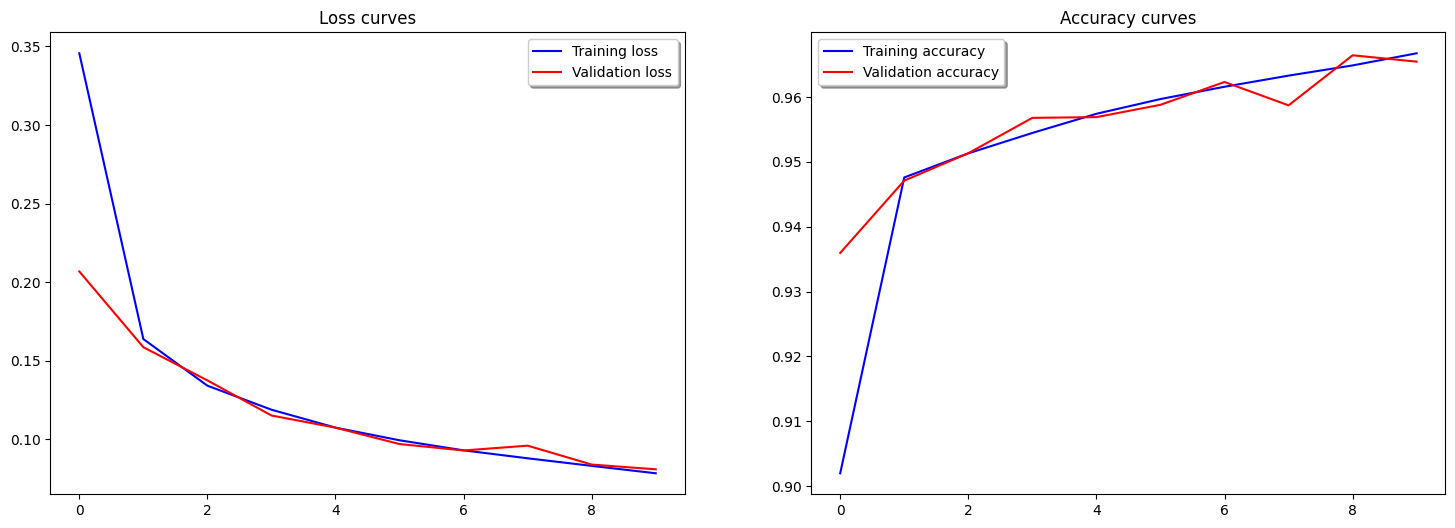

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

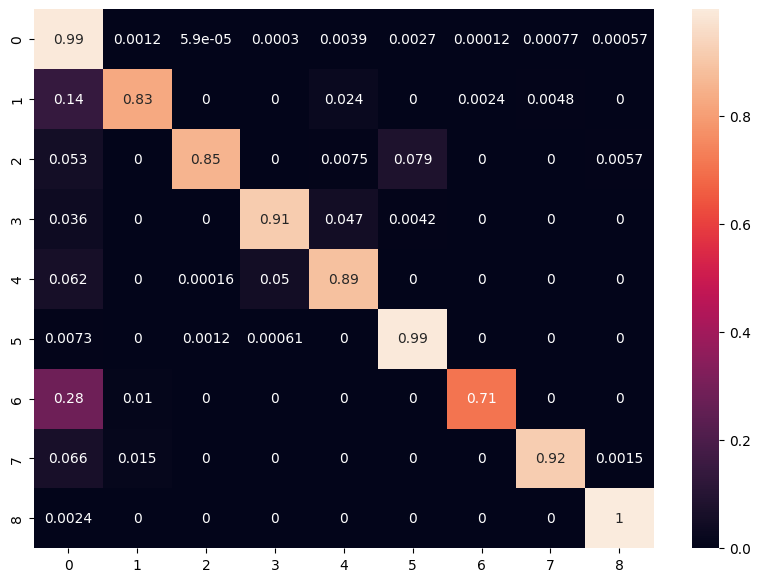

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9654458282504468
Confusion Matrix: 
 [[50325    61     3    15   196   136     6    39    29]
 [   59   348     0     0    10     0     1     2     0]
 [   28     0   453     0     4    42     0     0     3]
 [  104     0     0  2605   134    12     0     0     0]
 [  775     0     2   625 11038     0     0     0     0]
 [   12     0     2     1     0  1629     0     0     0]
 [   27     1     0     0     0     0    68     0     0]
 [   85    19     0     0     0     0     0  1187     2]
 [    1     0     0     0     0     0     0     0   409]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.81      0.83      0.82       420
           2       0.98      0.85      0.92       530
           3       0.80      0.91      0.85      2855
           4       0.97      0.89      0.93     12440
           5       0.90      0.99      0.94      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers and activation function swish

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="swish", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='swish'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_17 (LSTM)              (None, 10)                840       
                                                                 
 dense_8 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - 177s 32ms/step - loss: 0.4140 - accuracy: 0.8850 - val_loss: 0.2579 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 2/10
5485/5485 [==============================] - 172s 31ms/step - loss: 0.2366 - accuracy: 0.9323 - val_loss: 0.2352 - val_accuracy: 0.9298 - lr

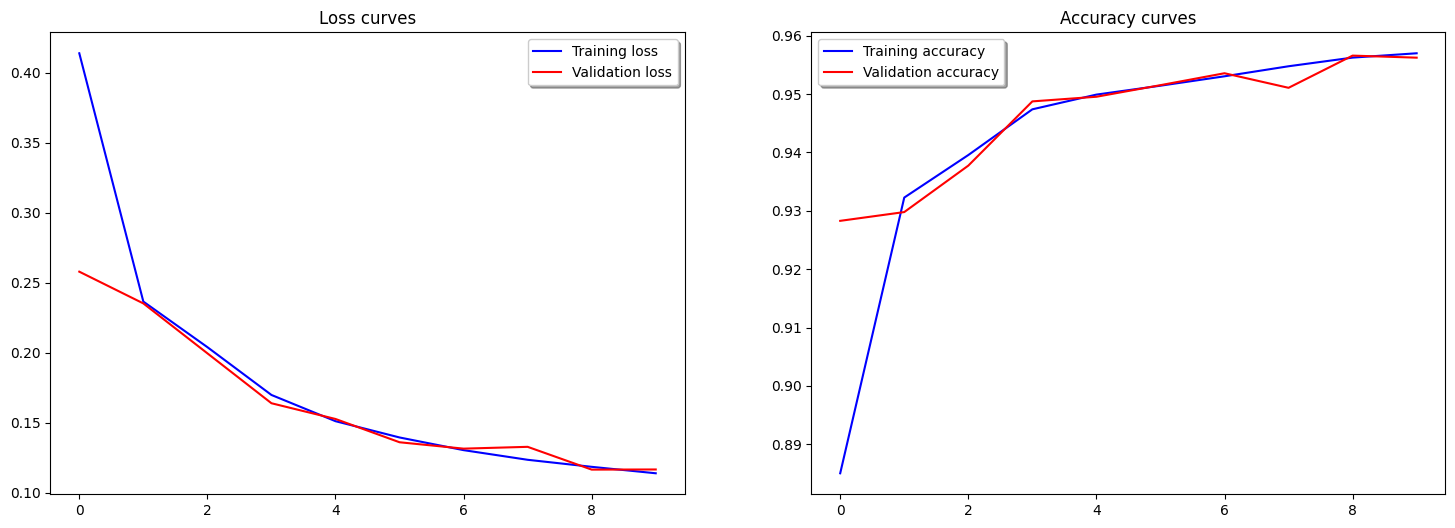

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 17s 7ms/step


<Axes: >

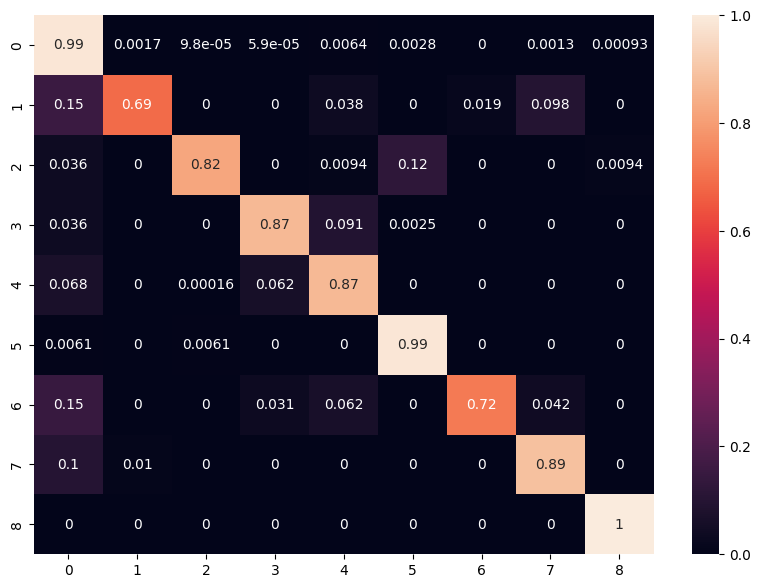

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9562398933303072
Confusion Matrix: 
 [[50132    87     5     3   325   144     0    67    47]
 [   65   290     0     0    16     0     8    41     0]
 [   19     0   435     0     5    66     0     0     5]
 [  104     0     0  2484   260     7     0     0     0]
 [  848     0     2   771 10819     0     0     0     0]
 [   10     0    10     0     0  1624     0     0     0]
 [   14     0     0     3     6     0    69     4     0]
 [  130    13     0     0     0     0     0  1150     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.74      0.69      0.72       420
           2       0.96      0.82      0.89       530
           3       0.76      0.87      0.81      2855
           4       0.95      0.87      0.91     12440
           5       0.88      0.99      0.93      1644
           6

In [ ]:
# Defining model LSTM with 10 hidden units and 5 layers
from keras.layers import RepeatVector

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10

model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(RepeatVector(NUM_HIDDEN))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'gru.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_19 (LSTM)              (None, 10)                840       
                                                                 
 repeat_vector (RepeatVector  (None, 10, 10)           0         
 )                                                               
                                                                 
 lstm_20 (LSTM)              (None, 10)                840       
                                                                 
 dense_9 (Dense)             (None, 9)                 99        
                                                                 
Total params: 2,459
Trainable params: 2,459
Non-trainable params: 0
___________________________________________________

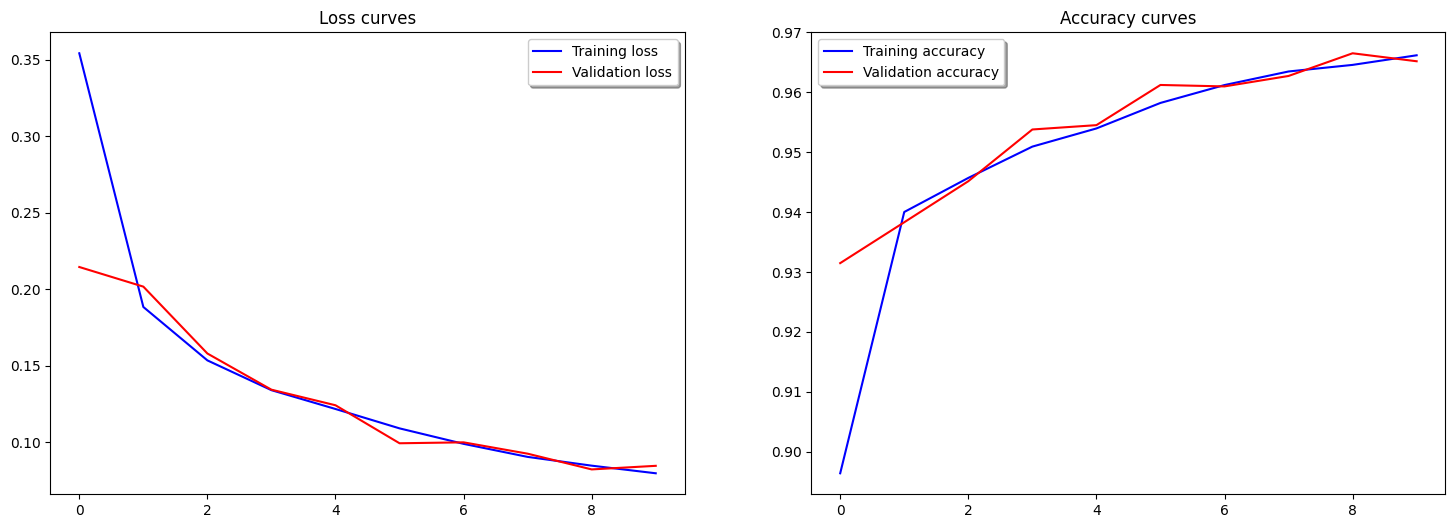

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

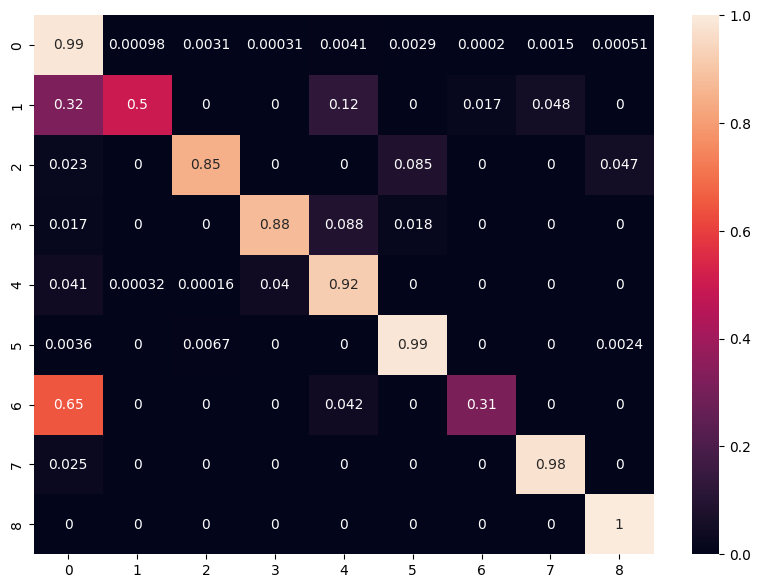

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9651905018582088
Confusion Matrix: 
 [[50121    50   157    16   208   147    10    75    26]
 [  133   209     0     0    51     0     7    20     0]
 [   12     0   448     0     0    45     0     0    25]
 [   49     0     0  2505   250    51     0     0     0]
 [  504     4     2   493 11437     0     0     0     0]
 [    6     0    11     0     0  1623     0     0     4]
 [   62     0     0     0     4     0    30     0     0]
 [   32     0     0     0     0     0     0  1261     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     50810
           1       0.79      0.50      0.61       420
           2       0.72      0.85      0.78       530
           3       0.83      0.88      0.85      2855
           4       0.96      0.92      0.94     12440
           5       0.87      0.99      0.92      1644
           6

In [ ]:
# Defining a GRU model with LeakyReLU activation function and 10 hidden units

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10

model = Sequential()
model.add(GRU(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
gru_path = path + 'gru.h5'
gru_callback = ModelCheckpoint(filepath=gru_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, gru_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 10)            540       
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense_10 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,299
Trainable params: 1,299
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5484/5485 [============================>.] - ETA: 0s - loss: 0.3477 - accuracy: 0.8973
Epoch 1: val_loss improved from inf to 0.23262, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/gru.h5
5485/5485 [==============================] - 173s 31ms/step - loss: 0.3478 - accuracy: 0.8973 - va

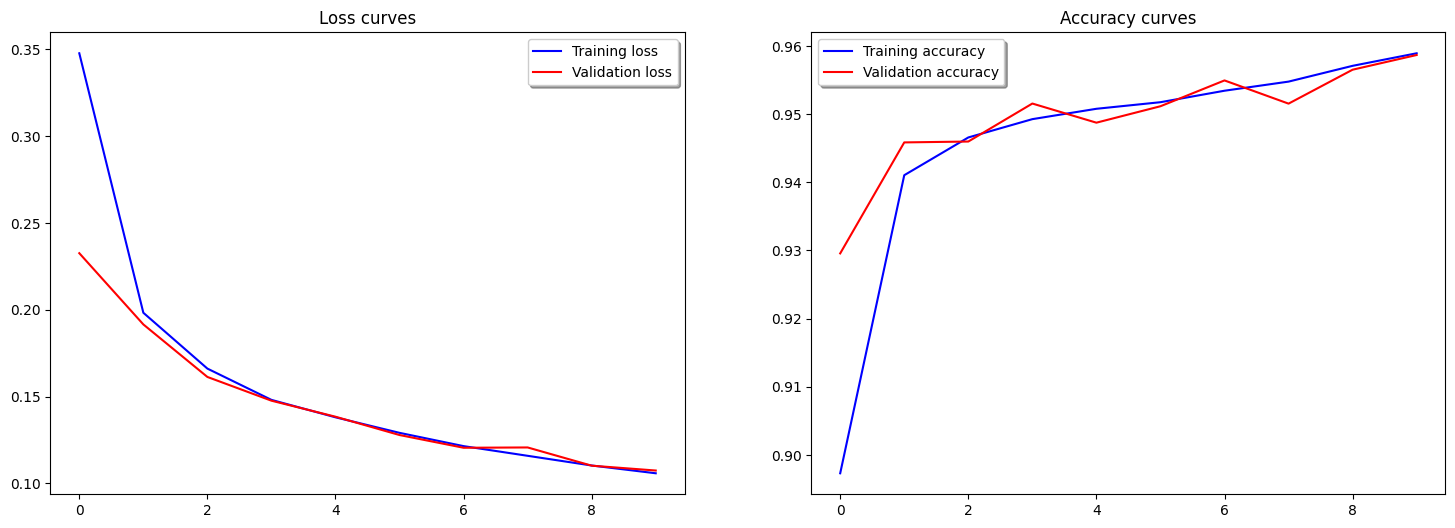

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 16s 7ms/step


<Axes: >

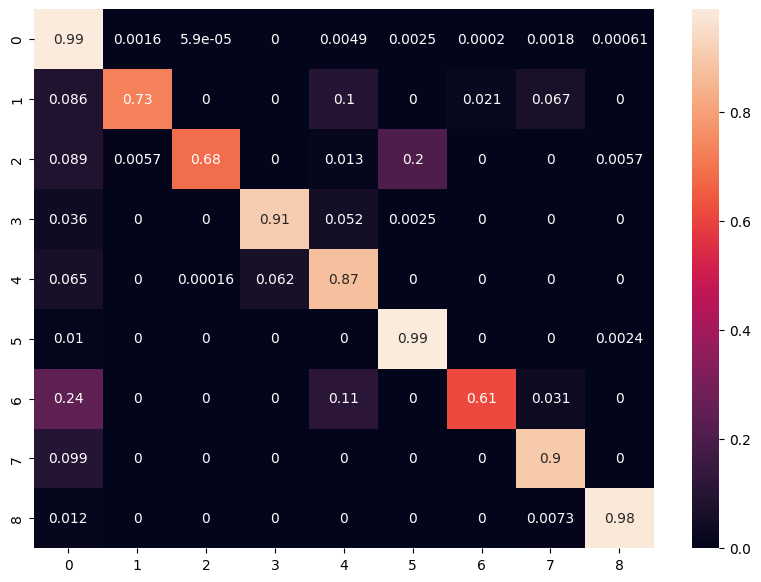

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9586796788561378
Confusion Matrix: 
 [[50216    83     3     0   249   127    10    91    31]
 [   36   305     0     0    42     0     9    28     0]
 [   47     3   363     0     7   107     0     0     3]
 [  104     0     0  2595   149     7     0     0     0]
 [  806     0     2   775 10857     0     0     0     0]
 [   17     0     0     0     0  1623     0     0     4]
 [   23     0     0     0    11     0    59     3     0]
 [  128     0     0     0     0     0     0  1165     0]
 [    5     0     0     0     0     0     0     3   402]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.78      0.73      0.75       420
           2       0.99      0.68      0.81       530
           3       0.77      0.91      0.83      2855
           4       0.96      0.87      0.91     12440
           5       0.87      0.99      0.93      1644
           6

In [ ]:
# Defining a GRU model with 20 hidden units

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10

model = Sequential()
model.add(GRU(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
gru_path = path + 'gru.h5'
gru_callback = ModelCheckpoint(filepath=gru_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, gru_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 20)            1680      
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_11 (Dense)            (None, 9)                 189       
                                                                 
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5485/5485 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9192
Epoch 1: val_loss improved from inf to 0.17073, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/gru.h5
5485/5485 [==============================] - 175s 31ms/step - loss: 0.2801 - accuracy: 0.9192 - va

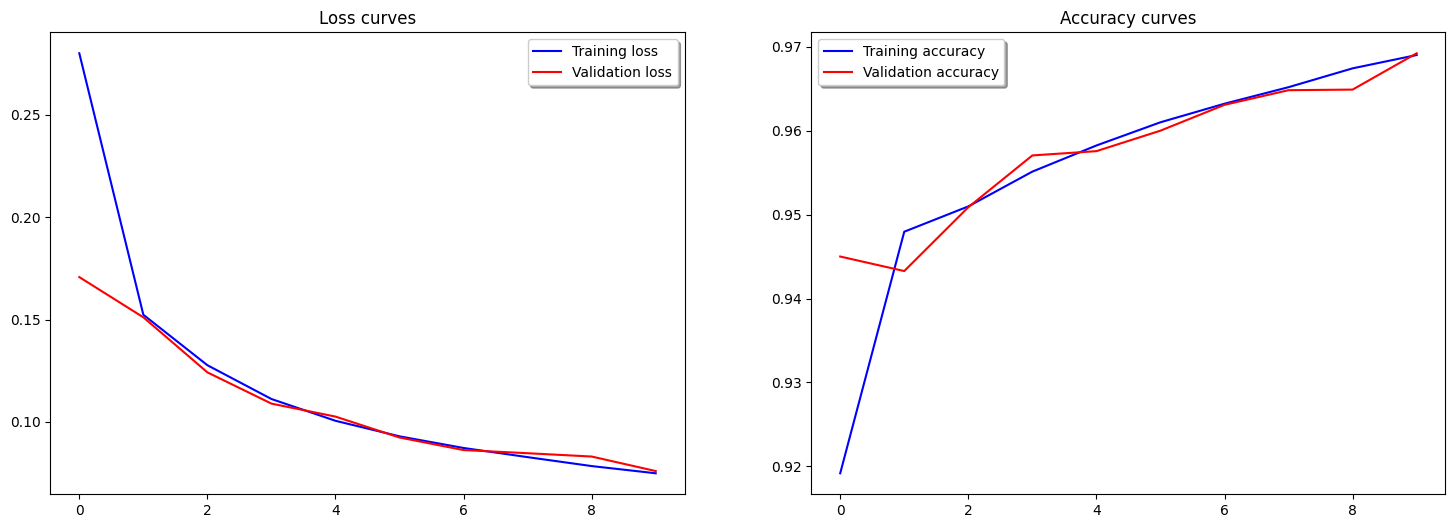

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

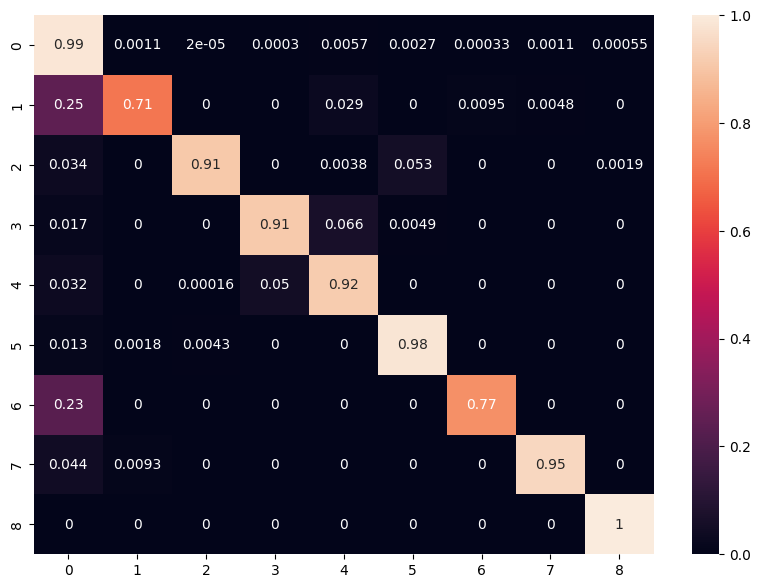

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9692189849357429
Confusion Matrix: 
 [[50206    55     1    15   291   139    17    58    28]
 [  103   299     0     0    12     0     4     2     0]
 [   18     0   481     0     2    28     0     0     1]
 [   48     0     0  2604   189    14     0     0     0]
 [  397     0     2   623 11418     0     0     0     0]
 [   22     3     7     0     0  1612     0     0     0]
 [   22     0     0     0     0     0    74     0     0]
 [   57    12     0     0     0     0     0  1224     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50810
           1       0.81      0.71      0.76       420
           2       0.98      0.91      0.94       530
           3       0.80      0.91      0.85      2855
           4       0.96      0.92      0.94     12440
           5       0.90      0.98      0.94      1644
           6

With SMOTE

In [ ]:
# SMOTE data augmentation for the train data

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_resampled.values),
                                     index=X_resampled.index,
                                     columns=X_resampled.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((1067463, 6), (70527, 6))

In [ ]:
train_scaled

P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL
0        0.935362 -1.546284 -0.806068  -0.698849  -0.963835    0.771734
1        1.649945  1.495658  0.931649   2.192419  -0.137314   -2.204885
2       -0.904399  0.388192  1.043563   0.871500   1.313827    0.381434
3        0.878568  0.470236  0.291695   1.390070   0.778733   -1.083165
4       -0.904399 -1.526184  0.977986  -0.912348   0.685406   -1.080520
...           ...       ...       ...        ...        ...         ...
1067458 -0.904399 -1.546284 -0.998823  -0.999383  -1.064944    0.771734
1067459 -0.904399 -1.546284 -0.998823  -0.999383  -1.064944    0.771734
1067460  1.649945  1.495658 -0.998823  -0.438833  -1.064944    0.771734
1067461 -0.904399 -1.546284 -0.998823  -0.949664  -1.064944    0.771734
1067462  1.649945  1.495658 -0.998823  -0.969410  -1.064944    0.771734

[1067463 rows x 6 columns]

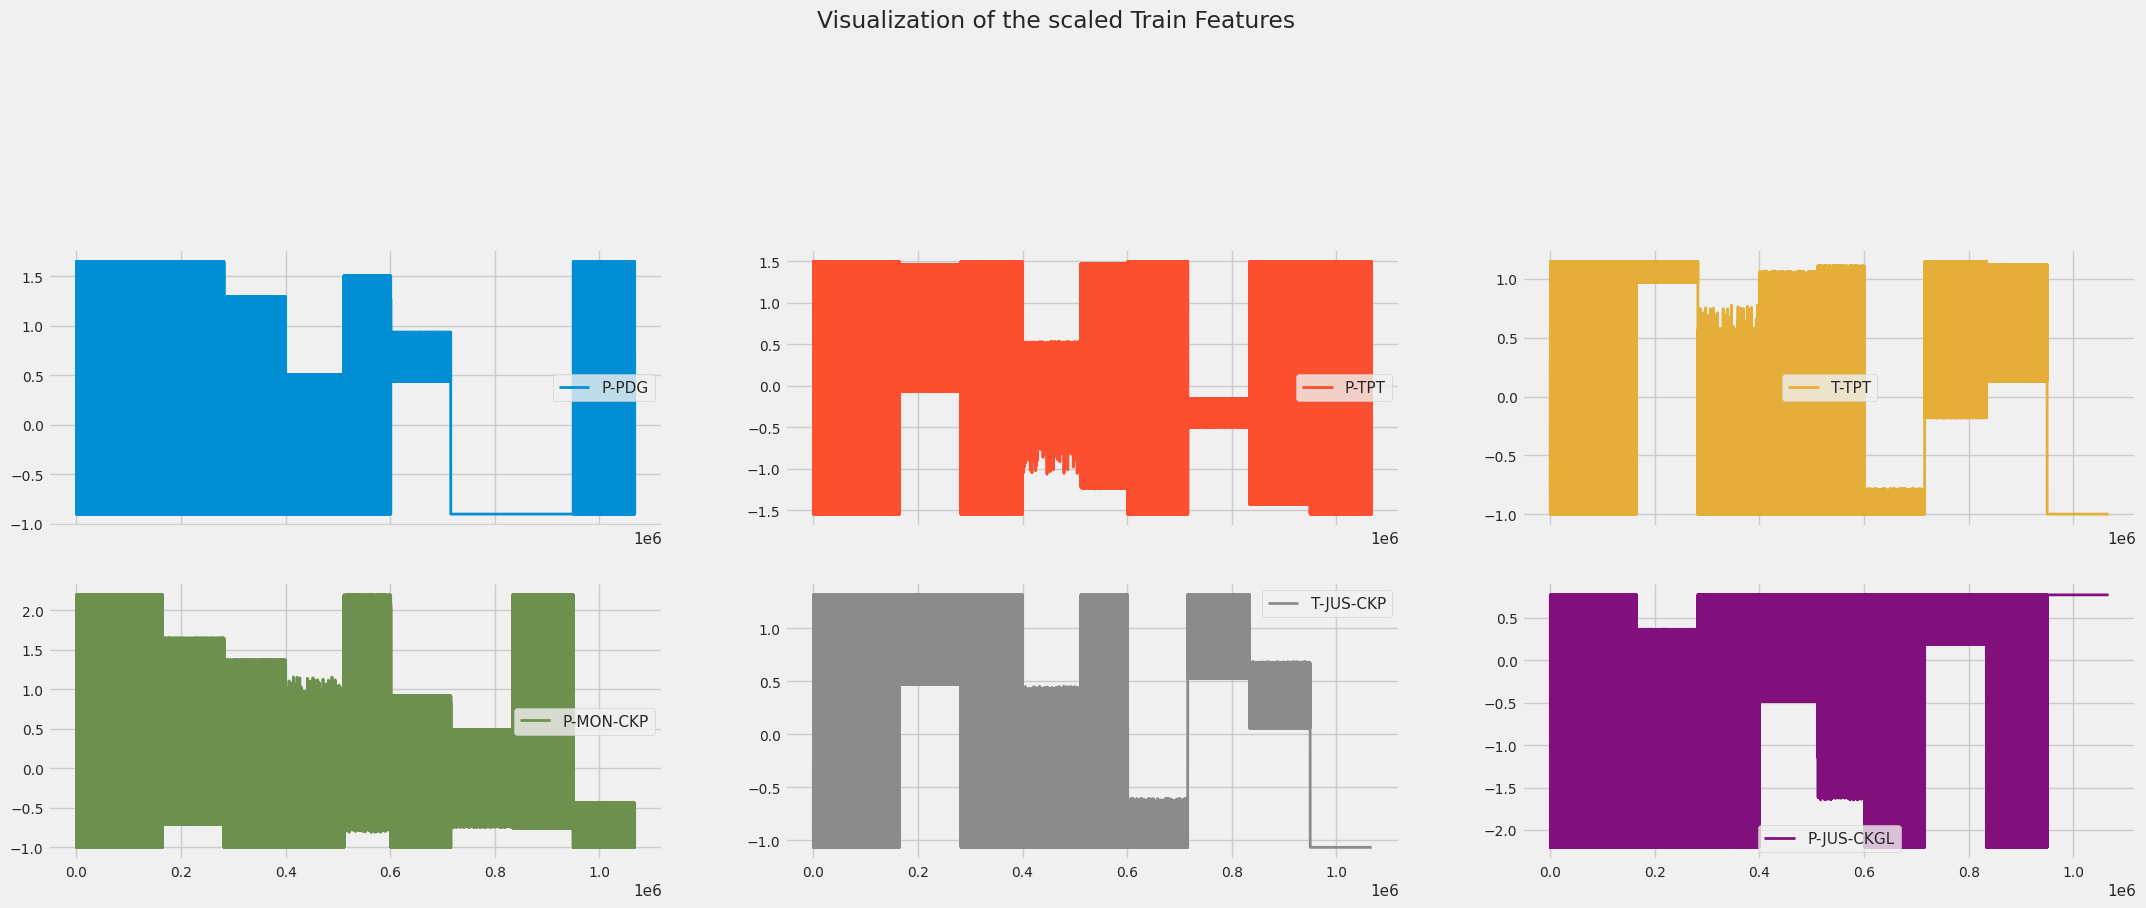

In [ ]:
# Plot the rescaled_train_features after SMOTE
plt.style.use('fivethirtyeight')
train_scaled.plot(subplots=True,
                           layout=(6, 3),
                           figsize=(24,24),
                           fontsize=10, 
                           linewidth=2, 
                           title='Visualization of the scaled Train Features')
plt.show()

In [ ]:
T = 30

X_train_1, y_train_1 = [], []
for i in range(y_resampled.shape[0] - (T-1)):
    X_train_1.append(train_scaled.iloc[i:i+T].values)
    y_train_1.append(y_resampled.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
    X_test_1.append(test_scaled.iloc[i:i+T].values)
    y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  

print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

Train data dimensions: (1067434, 30, 6), (1067434, 1)
Test data dimensions: (70498, 30, 6), (70498, 1)


In [ ]:
# Defining LSTM model with tanh activation

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="tanh", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='tanh'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'lstm.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_24 (LSTM)              (None, 10)                840       
                                                                 
 dense_13 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35581/35582 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9817
Epoch 1: val_loss improved from inf to 0.19207, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/lstm.h5
35582/35582 [==============================] - 1031s 29ms/step - loss: 0.0675 - accuracy: 0.981

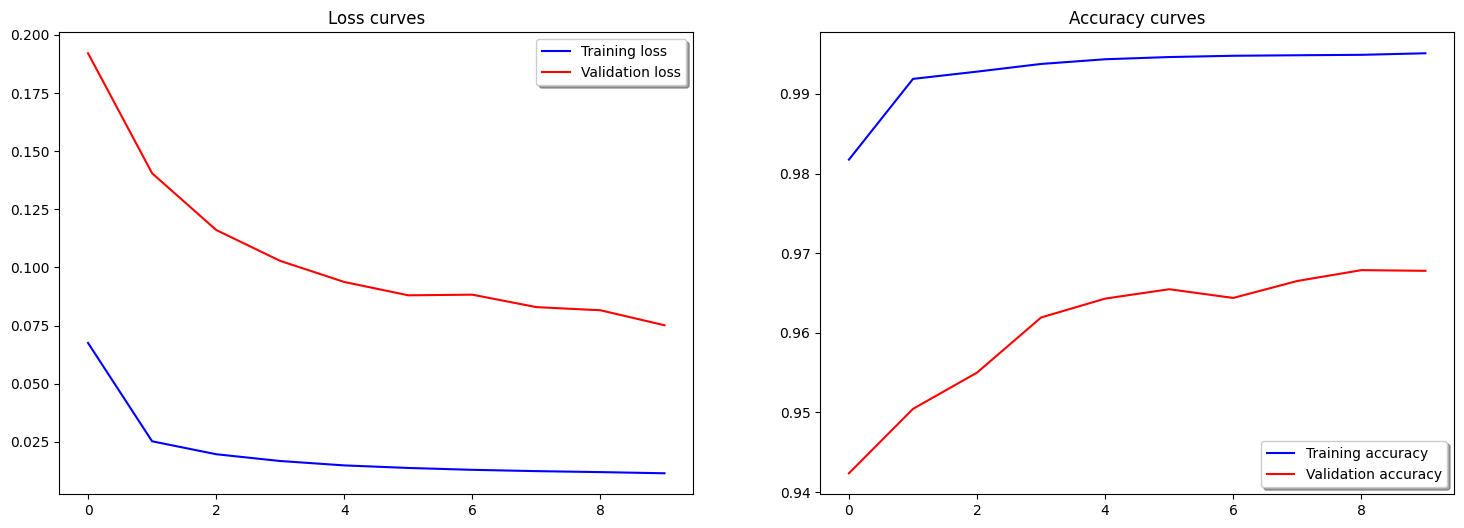

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

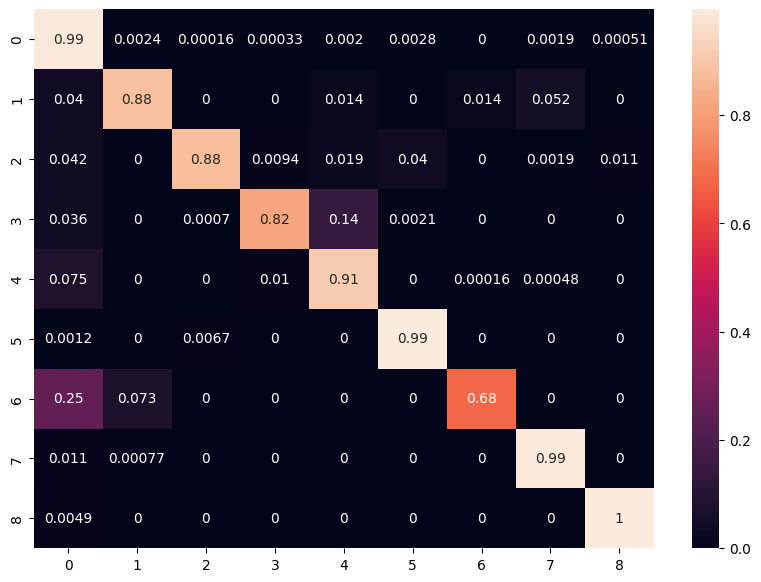

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))

In [ ]:
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9677863201792959
Confusion Matrix: 
 [[50298   123     8    17   103   141     0    94    26]
 [   17   369     0     0     6     0     6    22     0]
 [   22     0   465     5    10    21     0     1     6]
 [  103     0     2  2338   406     6     0     0     0]
 [  931     0     0   126 11375     0     2     6     0]
 [    2     0    11     0     0  1631     0     0     0]
 [   24     7     0     0     0     0    65     0     0]
 [   14     1     0     0     0     0     0  1278     0]
 [    2     0     0     0     0     0     0     0   408]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.74      0.88      0.80       420
           2       0.96      0.88      0.92       530
           3       0.94      0.82      0.88      2855
           4       0.96      0.91      0.93     12440
           5       0.91      0.99      0.95      1644
           6

In [ ]:
# Defining LSTM model with softmax activation

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="softmax", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='softmax'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'lstm.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_26 (LSTM)              (None, 10)                840       
                                                                 
 dense_14 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35581/35582 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8074
Epoch 1: val_loss improved from inf to 0.50107, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/lstm.h5
35582/35582 [==============================] - 988s 28ms/step - loss: 0.4402 - accuracy: 0.8074

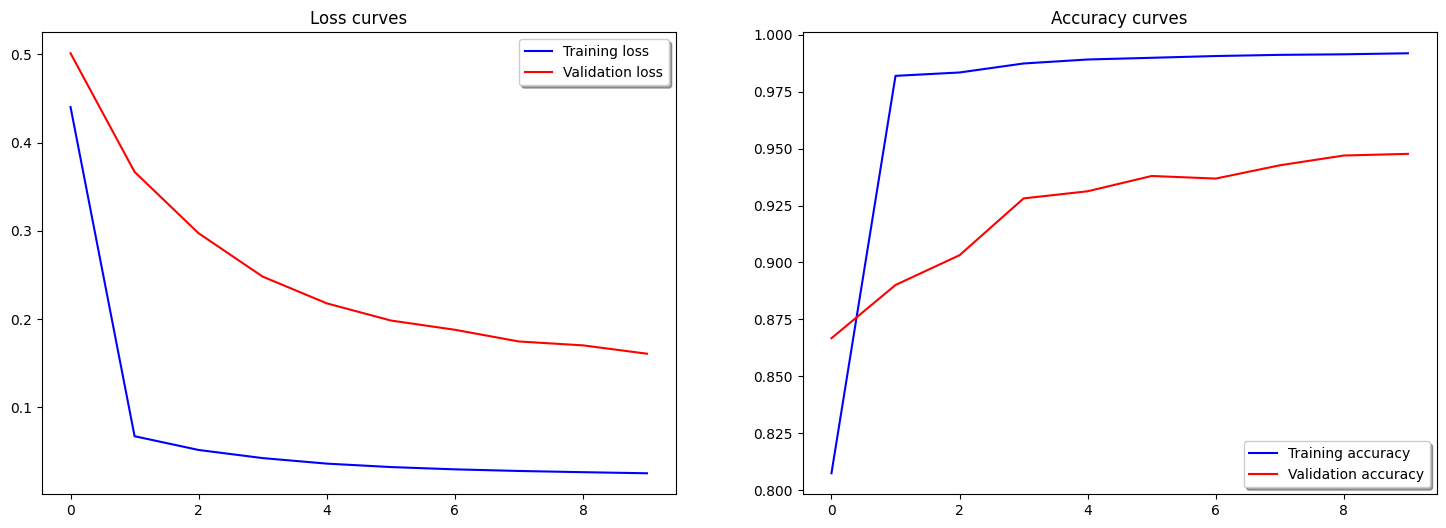

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 19s 9ms/step


<Axes: >

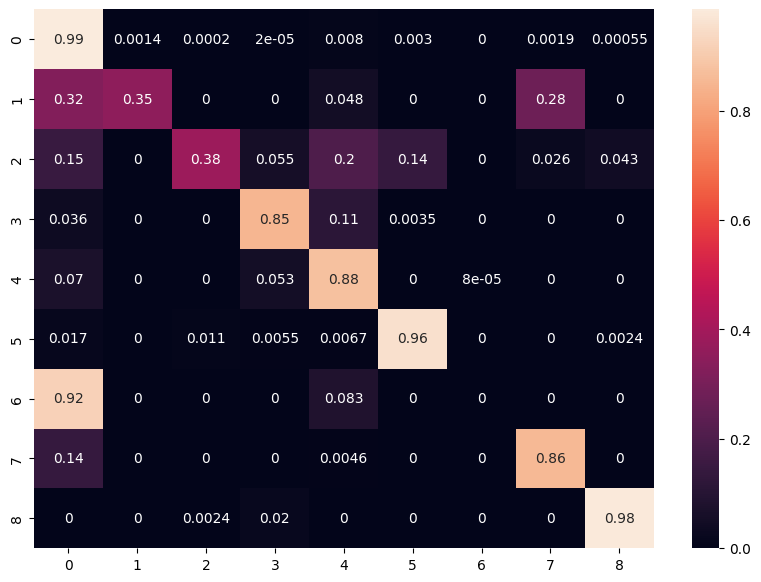

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))

In [ ]:
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9477006439899004
Confusion Matrix: 
 [[50050    72    10     1   404   151     0    94    28]
 [  136   148     0     0    20     0     0   116     0]
 [   79     0   203    29   108    74     0    14    23]
 [  103     0     0  2421   321    10     0     0     0]
 [  874     0     0   657 10908     0     1     0     0]
 [   28     0    18     9    11  1574     0     0     4]
 [   88     0     0     0     8     0     0     0     0]
 [  181     0     0     0     6     0     0  1106     0]
 [    0     0     1     8     0     0     0     0   401]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     50810
           1       0.67      0.35      0.46       420
           2       0.88      0.38      0.53       530
           3       0.77      0.85      0.81      2855
           4       0.93      0.88      0.90     12440
           5       0.87      0.96      0.91      1644
           6

In [ ]:
# Defining LSTM model with relu activation

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'lstm.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 10)            680       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35582/35582 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9776
Epoch 1: val_loss improved from inf to 0.24799, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/lstm.h5
35582/35582 [==============================] - 860s 24ms/step - loss: 0.0771 - accuracy: 0.9776 - 

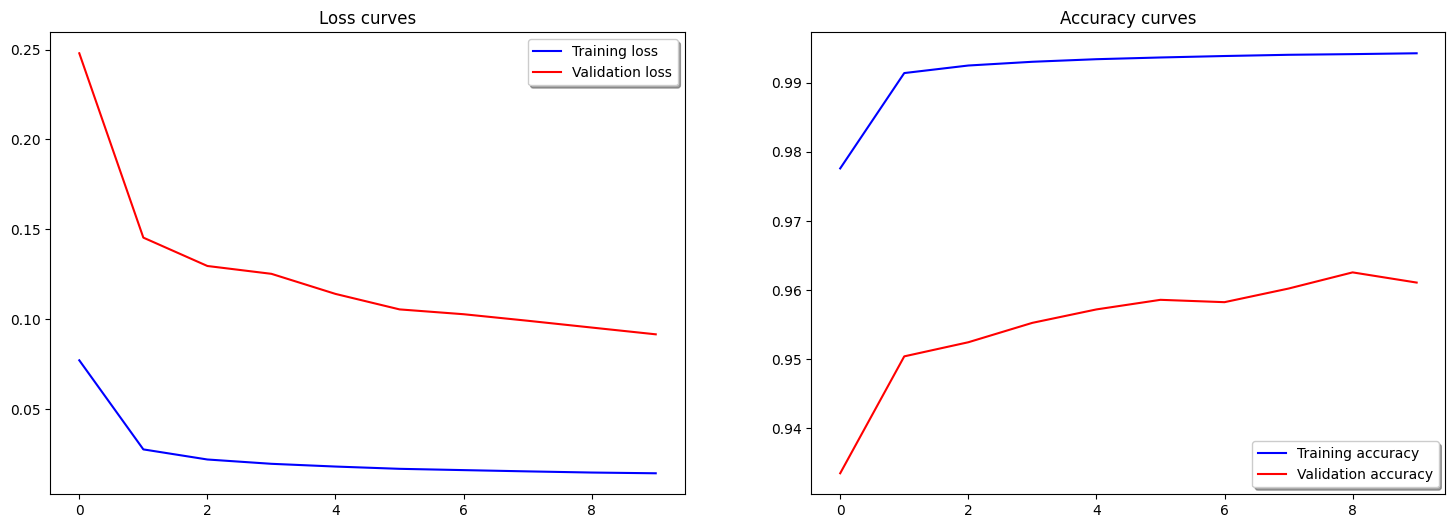

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 16s 7ms/step


In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9610910947828307
Confusion Matrix: 
 [[49802    94     9     0   626   143     1   102    33]
 [    7   368     0     0     8     0     5    32     0]
 [   21     0   485     1     1    21     0     0     1]
 [  101     0     0  2023   724     7     0     0     0]
 [  584     0     2   120 11734     0     0     0     0]
 [    3     0    27     0     3  1610     0     1     0]
 [   39     2     0     0     6     0    49     0     0]
 [   19     0     0     0     0     0     0  1274     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50810
           1       0.79      0.88      0.83       420
           2       0.93      0.92      0.92       530
           3       0.94      0.71      0.81      2855
           4       0.90      0.94      0.92     12440
           5       0.90      0.98      0.94      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers and activation "relu" each 20 hidden units 

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'lstm.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 20)            2160      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 9)                 189       
                                                                 
Total params: 5,629
Trainable params: 5,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35582/35582 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9827
Epoch 1: val_loss improved from inf to 0.18639, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/lstm.h5
35582/35582 [==============================] - 865s 24ms/step - loss: 0.0694 - accuracy: 0.9827 - 

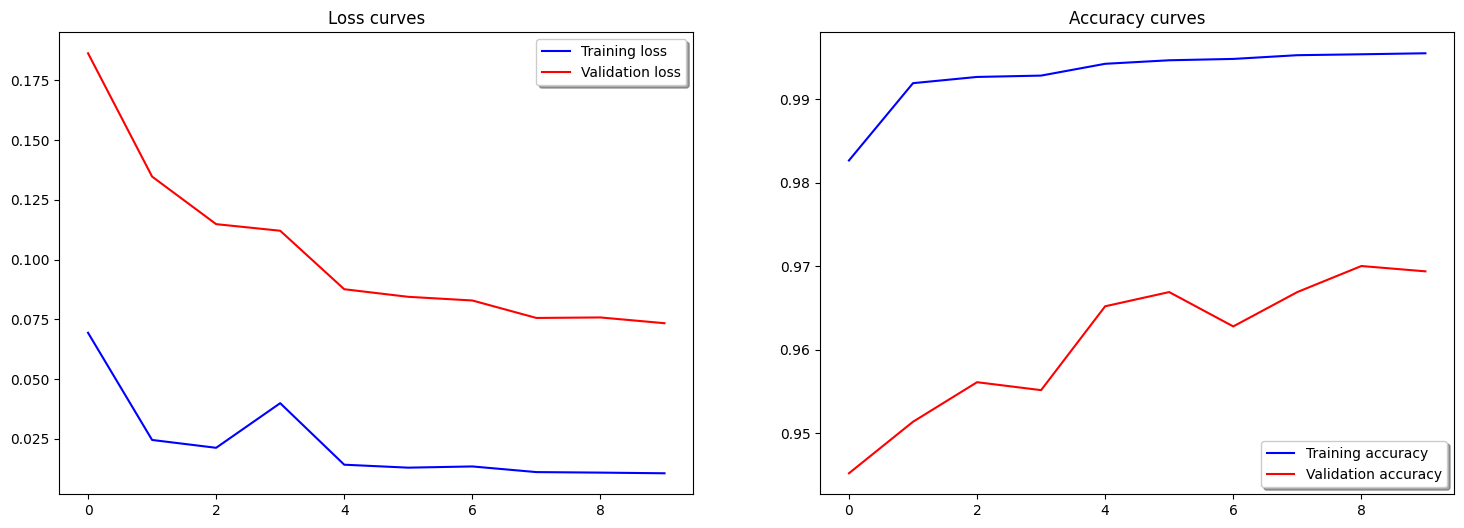

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 16s 7ms/step


<Axes: >

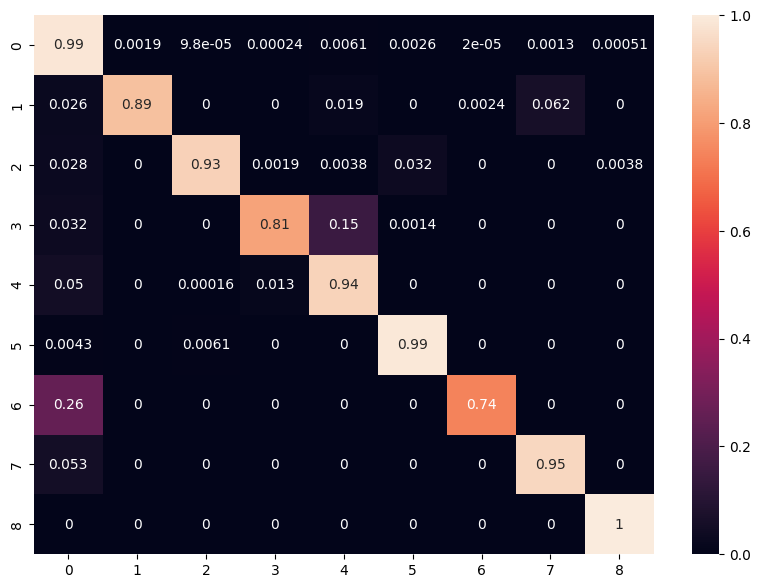

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))

In [ ]:
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.969403387330137
Confusion Matrix: 
 [[50165    96     5    12   308   132     1    65    26]
 [   11   374     0     0     8     0     1    26     0]
 [   15     0   493     1     2    17     0     0     2]
 [   90     0     0  2320   441     4     0     0     0]
 [  617     0     2   165 11656     0     0     0     0]
 [    7     0    10     0     0  1627     0     0     0]
 [   25     0     0     0     0     0    71     0     0]
 [   68     0     0     0     0     0     0  1225     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     50810
           1       0.80      0.89      0.84       420
           2       0.97      0.93      0.95       530
           3       0.93      0.81      0.87      2855
           4       0.94      0.94      0.94     12440
           5       0.91      0.99      0.95      1644
           6 

In [ ]:
# LSTM model with 2 stucked LSTM layers and activation function LeakyReLU

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 10)            680       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35582/35582 [==============================] - 884s 25ms/step - loss: 0.0723 - accuracy: 0.9797 - val_loss: 0.2340 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 2/10
35582/35582 [==============================] - 876s 25ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 0.1601 - val_accuracy: 0.9471 

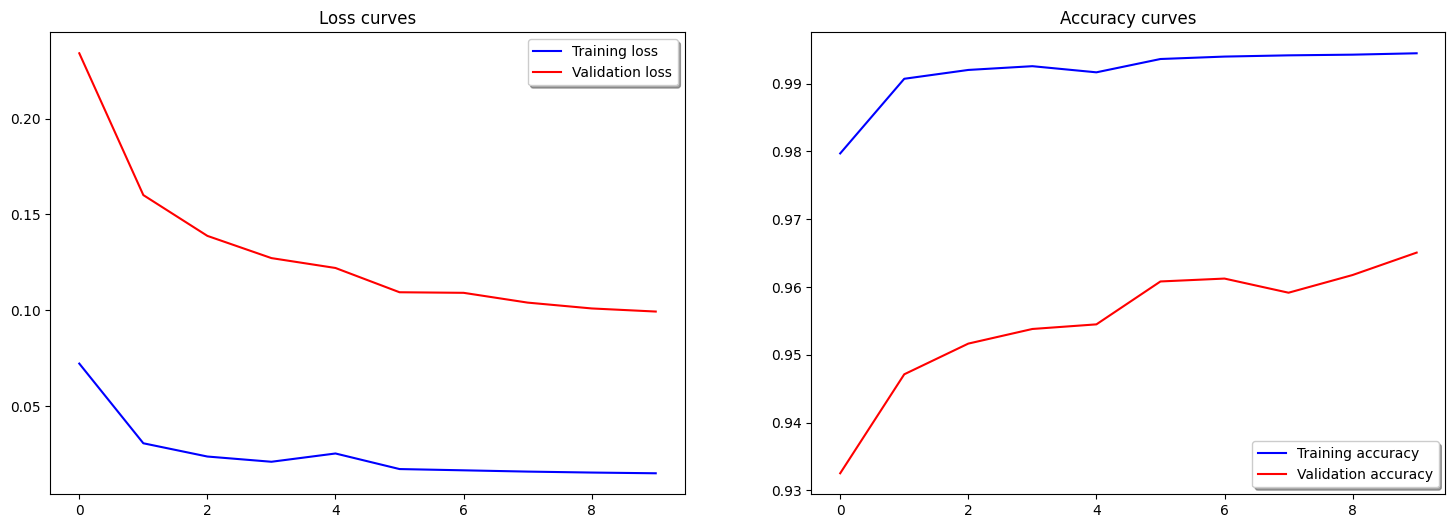

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 16s 7ms/step


In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
    
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9650770234616585
Confusion Matrix: 
 [[50279    86     4    14   153   145     2   101    26]
 [   37   339     0     0     6     0     0    38     0]
 [   12     0   473     6     1    36     0     0     2]
 [  104     0     0  2319   419    13     0     0     0]
 [  917     1     2   228 11292     0     0     0     0]
 [    6     0    15     0     0  1623     0     0     0]
 [   18     0     0     0     0     0    78     0     0]
 [   66     0     0     0     4     0     0  1223     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     50810
           1       0.80      0.81      0.80       420
           2       0.96      0.89      0.92       530
           3       0.90      0.81      0.86      2855
           4       0.95      0.91      0.93     12440
           5       0.89      0.99      0.94      1644
           6

In [ ]:
# LSTM model with 2 stucked LSTM layers, activation function LeakyReLU and 20 hidden units

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 20)            2160      
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dense_3 (Dense)             (None, 9)                 189       
                                                                 
Total params: 5,629
Trainable params: 5,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35582/35582 [==============================] - 932s 26ms/step - loss: 0.0775 - accuracy: 0.9787 - val_loss: 0.2381 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 2/10
35582/35582 [==============================] - 916s 26ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.1467 - val_accuracy: 0.9488 

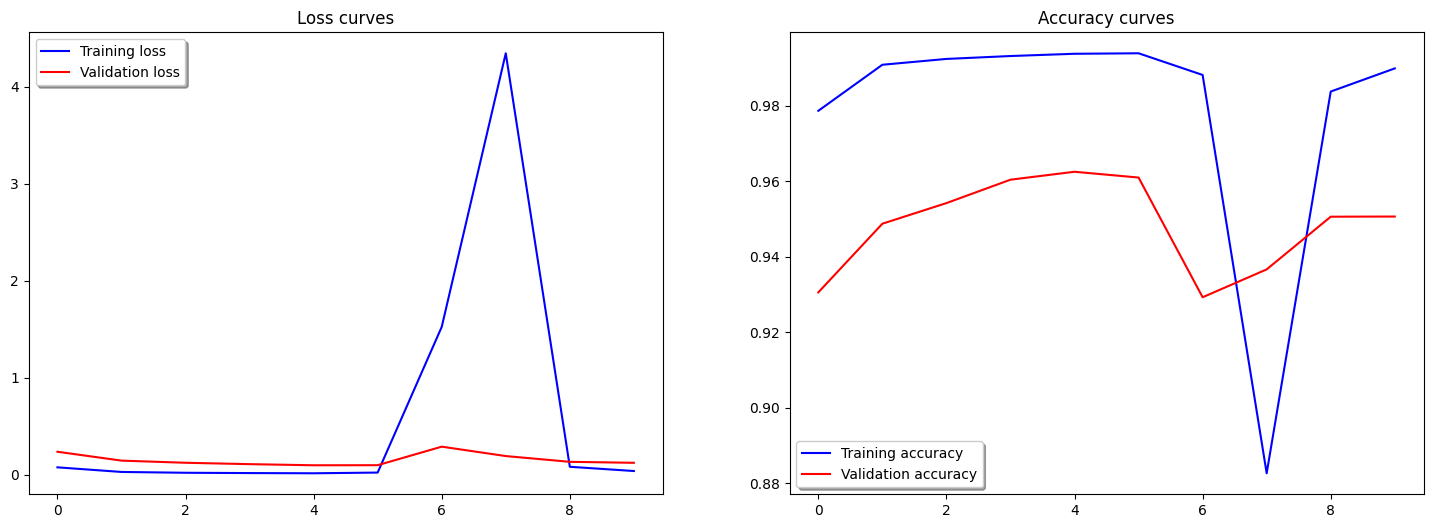

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 17s 8ms/step


<Axes: >

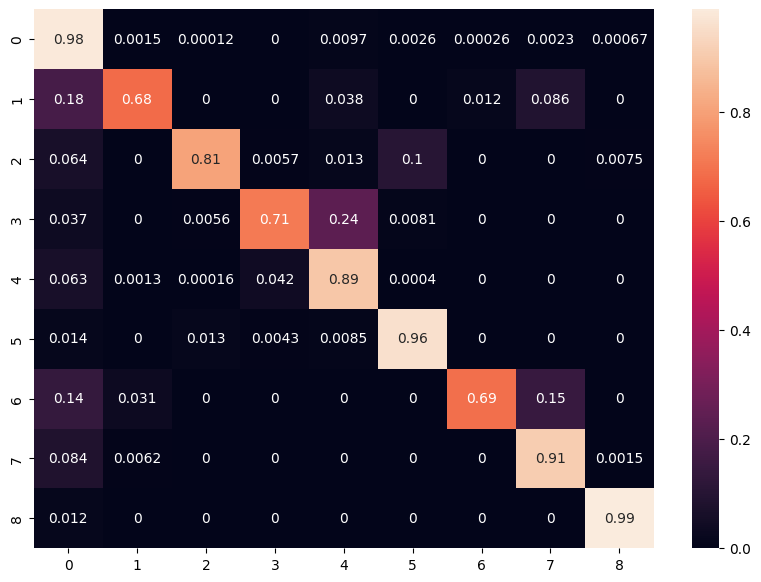

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
    
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9506510823002071
Confusion Matrix: 
 [[49942    74     6     0   492   133    13   116    34]
 [   77   286     0     0    16     0     5    36     0]
 [   34     0   427     3     7    55     0     0     4]
 [  107     0    16  2029   680    23     0     0     0]
 [  778    16     2   528 11111     5     0     0     0]
 [   23     0    21     7    14  1579     0     0     0]
 [   13     3     0     0     0     0    66    14     0]
 [  109     8     0     0     0     0     0  1174     2]
 [    5     0     0     0     0     0     0     0   405]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50810
           1       0.74      0.68      0.71       420
           2       0.90      0.81      0.85       530
           3       0.79      0.71      0.75      2855
           4       0.90      0.89      0.90     12440
           5       0.88      0.96      0.92      1644
           6

In [ ]:
# Defining LSTM model with swish activation

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="swish", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='swish'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'lstm.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 10)            680       
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                                 
 dense_4 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35581/35582 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9769
Epoch 1: val_loss improved from inf to 0.25802, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/lstm.h5
35582/35582 [==============================] - 1013s 28ms/step - loss: 0.0819 - accuracy: 0.9769

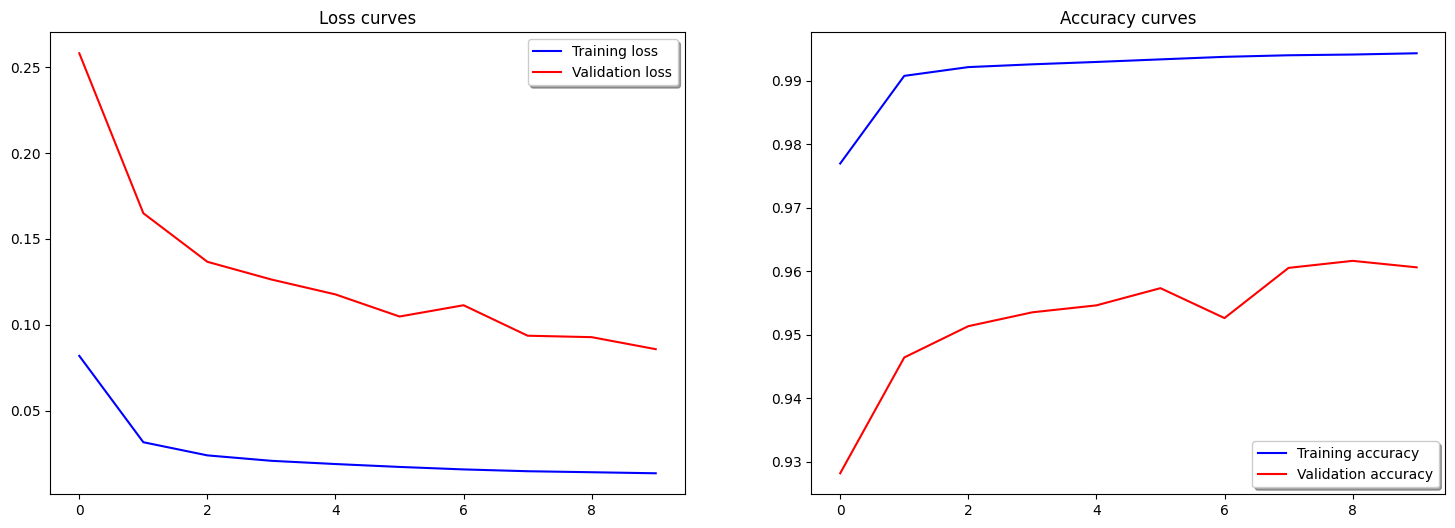

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 18s 8ms/step


<Axes: >

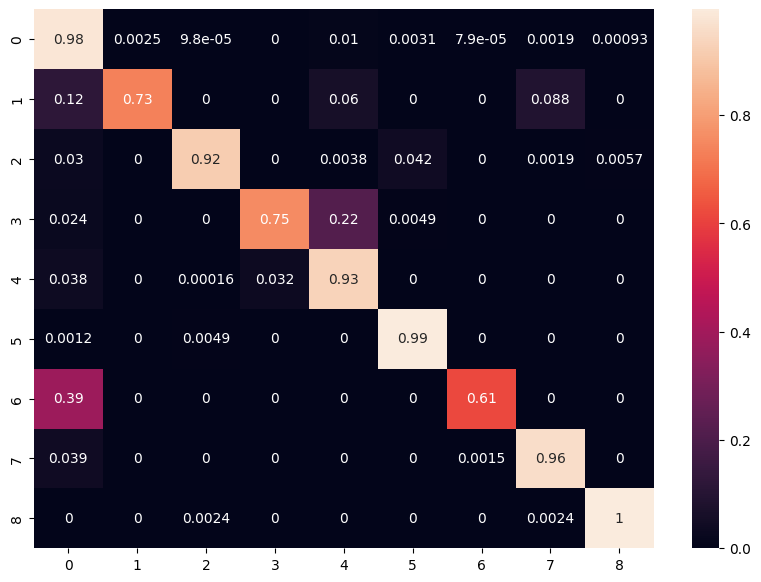

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
    
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9605946267979233
Confusion Matrix: 
 [[49864   125     5     0   515   156     4    94    47]
 [   50   308     0     0    25     0     0    37     0]
 [   16     0   486     0     2    22     0     1     3]
 [   68     0     0  2155   618    14     0     0     0]
 [  472     0     2   400 11566     0     0     0     0]
 [    2     0     8     0     0  1634     0     0     0]
 [   37     0     0     0     0     0    59     0     0]
 [   51     0     0     0     0     0     2  1240     0]
 [    0     0     1     0     0     0     0     1   408]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     50810
           1       0.71      0.73      0.72       420
           2       0.97      0.92      0.94       530
           3       0.84      0.75      0.80      2855
           4       0.91      0.93      0.92     12440
           5       0.89      0.99      0.94      1644
           6

In [ ]:
# Defining model LSTM with 10 hidden units and 5 layers

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10

model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(RepeatVector(NUM_HIDDEN))
model.add(LSTM(NUM_HIDDEN, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
lstm_path = path + 'gru.h5'
lstm_callback = ModelCheckpoint(filepath=lstm_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, lstm_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 10)            680       
                                                                 
 lstm_11 (LSTM)              (None, 10)                840       
                                                                 
 repeat_vector (RepeatVector  (None, 10, 10)           0         
 )                                                               
                                                                 
 lstm_12 (LSTM)              (None, 10)                840       
                                                                 
 dense_5 (Dense)             (None, 9)                 99        
                                                                 
Total params: 2,459
Trainable params: 2,459
Non-trainable params: 0
____________________________________________________

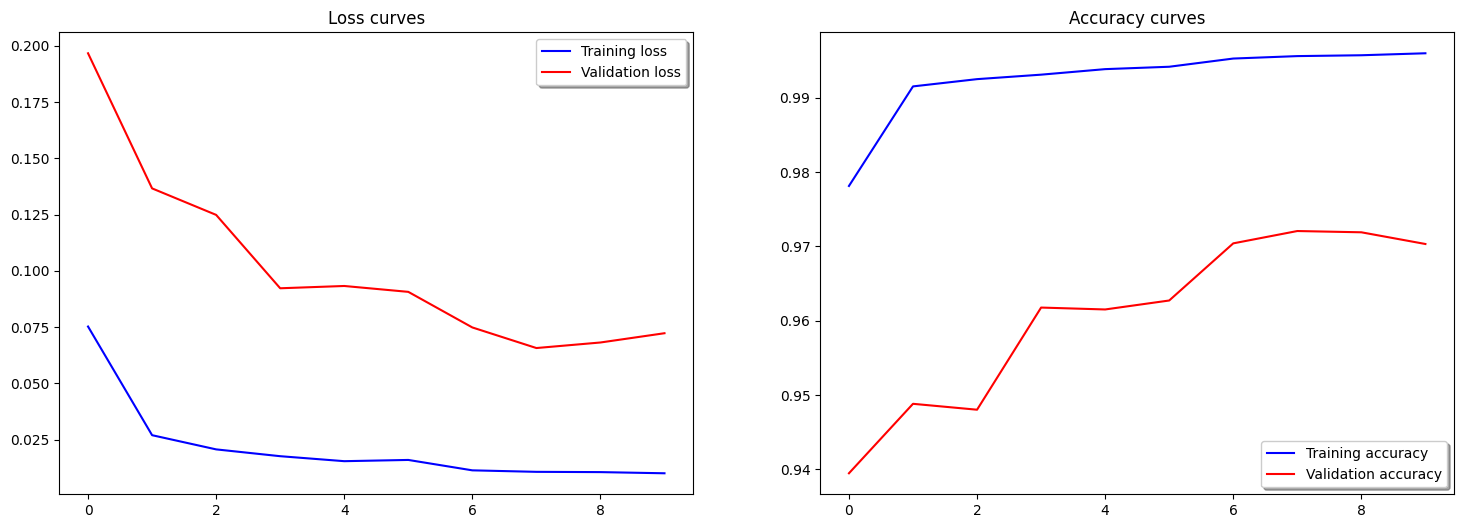

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 20s 9ms/step


<Axes: >

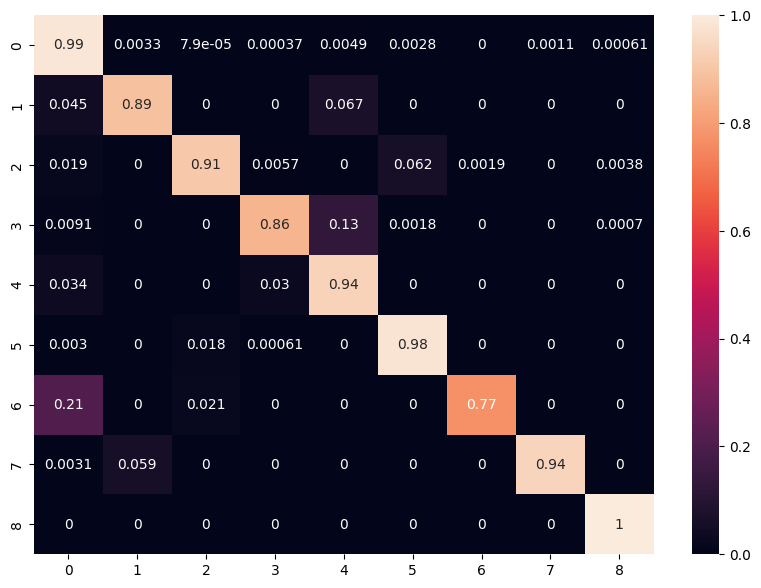

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9703253993021078
Confusion Matrix: 
 [[50140   166     4    19   250   143     0    57    31]
 [   19   373     0     0    28     0     0     0     0]
 [   10     0   481     3     0    33     1     0     2]
 [   26     0     0  2453   369     5     0     0     2]
 [  418     0     0   368 11654     0     0     0     0]
 [    5     0    30     1     0  1608     0     0     0]
 [   20     0     2     0     0     0    74     0     0]
 [    4    76     0     0     0     0     0  1213     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50810
           1       0.61      0.89      0.72       420
           2       0.93      0.91      0.92       530
           3       0.86      0.86      0.86      2855
           4       0.95      0.94      0.94     12440
           5       0.90      0.98      0.94      1644
           6

In [ ]:
# Defining GRU model with LeakyReLU activation and 10 hidden units

NUM_HIDDEN = 10
BATCH = 30
EPOCH = 10
# Define a GRU model
model = Sequential()
model.add(GRU(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
gru_path = path + 'gru.h5'
gru_callback = ModelCheckpoint(filepath=gru_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, gru_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 10)            540       
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense_6 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,299
Trainable params: 1,299
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35581/35582 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817
Epoch 1: val_loss improved from inf to 0.23623, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/gru.h5
35582/35582 [==============================] - 956s 27ms/step - loss: 0.0632 - accuracy: 0.9817 -

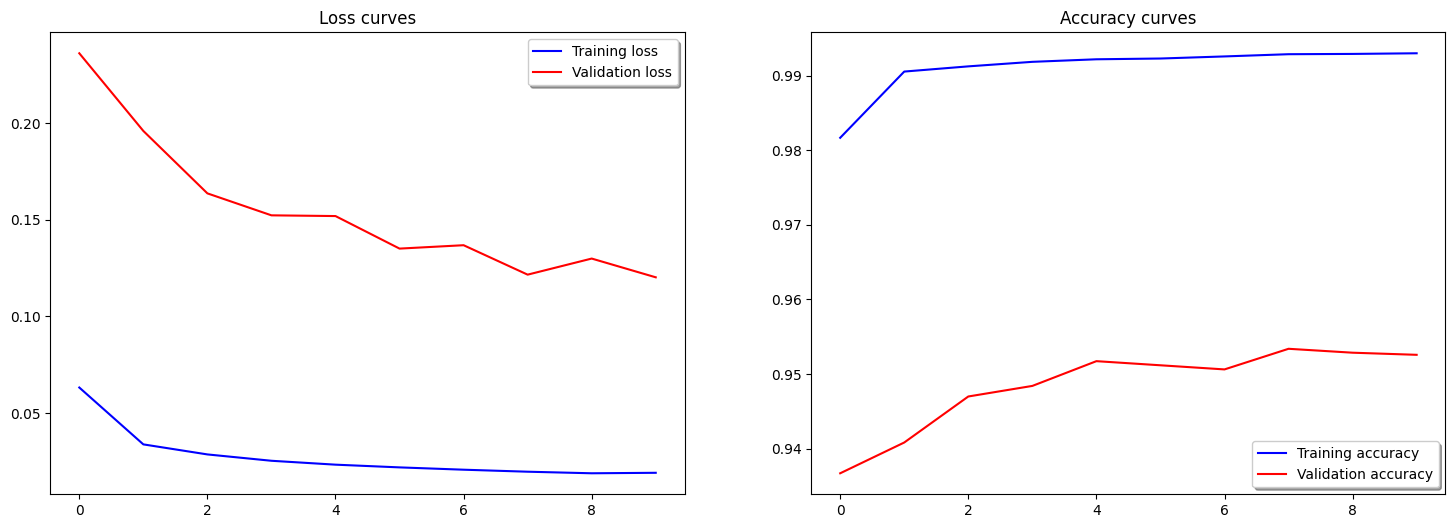

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

#for i in range(y_pred.shape[0]):
#    print(y_pred[i], y_test_1[i])

2204/2204 [==============================] - 16s 7ms/step


<Axes: >

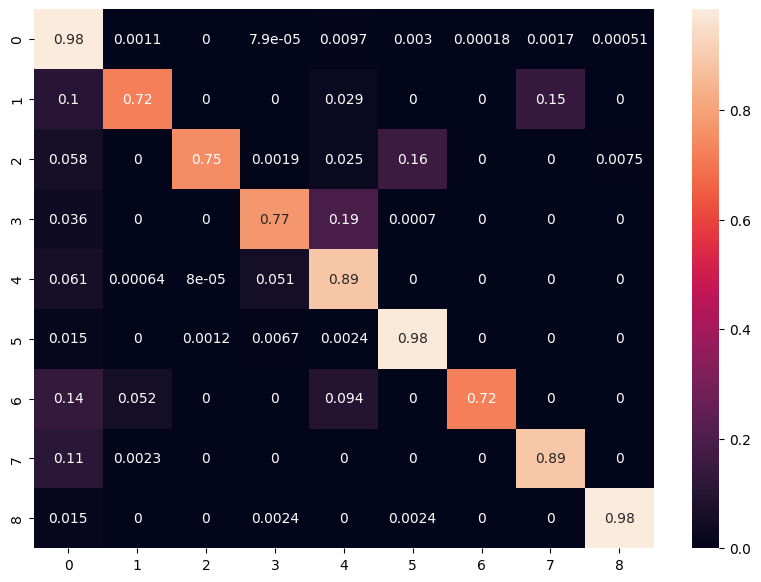

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9525802150415614
Confusion Matrix: 
 [[49987    55     0     4   491   153     9    85    26]
 [   44   303     0     0    12     0     0    61     0]
 [   31     0   398     1    13    83     0     0     4]
 [  104     0     0  2211   538     2     0     0     0]
 [  761     8     1   638 11032     0     0     0     0]
 [   24     0     2    11     4  1603     0     0     0]
 [   13     5     0     0     9     0    69     0     0]
 [  140     3     0     0     0     0     0  1150     0]
 [    6     0     0     1     0     1     0     0   402]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50810
           1       0.81      0.72      0.76       420
           2       0.99      0.75      0.85       530
           3       0.77      0.77      0.77      2855
           4       0.91      0.89      0.90     12440
           5       0.87      0.98      0.92      1644
           6

In [ ]:
# Defining GRU model with LeakyReLU activation and 20 hidden units

NUM_HIDDEN = 20
BATCH = 30
EPOCH = 10
# Define a GRU model
model = Sequential()
model.add(GRU(NUM_HIDDEN, activation="LeakyReLU", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(NUM_HIDDEN, activation='LeakyReLU'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Save the best model
gru_path = path + 'gru.h5'
gru_callback = ModelCheckpoint(filepath=gru_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop, gru_callback])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 20)            1680      
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_7 (Dense)             (None, 9)                 189       
                                                                 
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35580/35582 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9873
Epoch 1: val_loss improved from inf to 0.14750, saving model to /content/gdrive/My Drive/Thesis/3W_dataset/gru.h5
35582/35582 [==============================] - 979s 27ms/step - loss: 0.0420 - accuracy: 0.9873 -

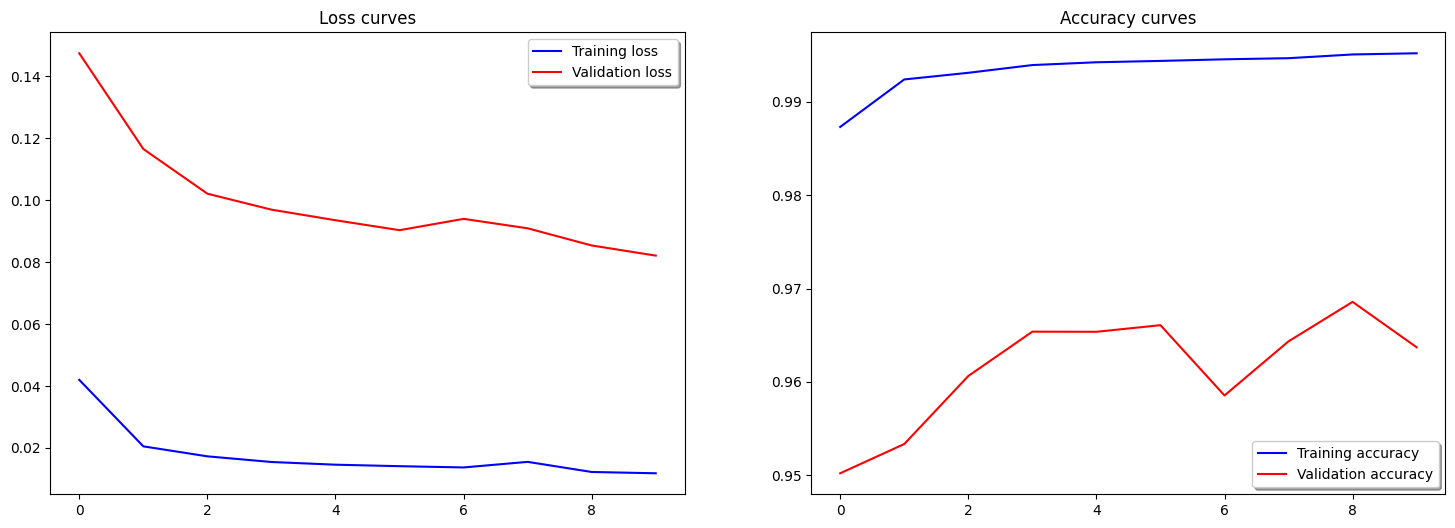

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 17s 8ms/step


<Axes: >

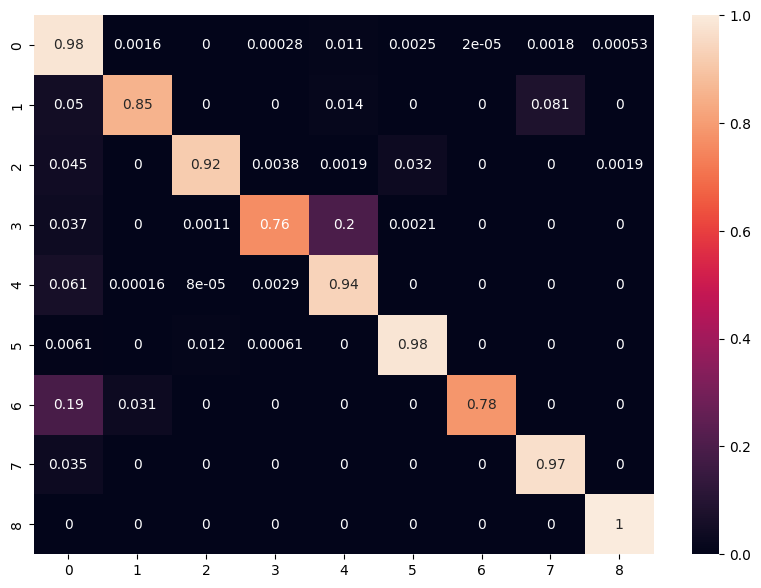

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9637010979034866
Confusion Matrix: 
 [[49924    81     0    14   546   126     1    91    27]
 [   21   359     0     0     6     0     0    34     0]
 [   24     0   485     2     1    17     0     0     1]
 [  105     0     3  2182   559     6     0     0     0]
 [  759     2     1    36 11642     0     0     0     0]
 [   10     0    19     1     0  1614     0     0     0]
 [   18     3     0     0     0     0    75     0     0]
 [   45     0     0     0     0     0     0  1248     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     50810
           1       0.81      0.85      0.83       420
           2       0.95      0.92      0.93       530
           3       0.98      0.76      0.86      2855
           4       0.91      0.94      0.92     12440
           5       0.92      0.98      0.95      1644
           6